In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import plotly.express as px
import plotly
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import networkx as nx
import networkx as nx
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sns.set_theme()

In [2]:
from src.utils.story.processing import (
    remove_low_alcohol,
    shift_past_count,
    create_time_variables,
)

from src.utils.story.selection import (
    compute_cumulative_ratings_count,
    remove_before_month,
)

from src.utils.story.beer_knowledge import (
    number_of_beer_per_style,
    add_all_knowledge,
    add_experts,
    get_beer_required_expert,
    get_expert_count,
    get_mean_expert_vs_non,
)

from src.utils.story.nlp import tukey_test, create_digraph

from src.utils.story.preferences import analyse_relationships, create_preference_digraph

# 1. Pre-processing

In [3]:
df_ba_beers = pd.read_csv("src/data/beer_advocate/beers.csv")
# df_ba_breweries = pd.read_csv('src/data/beer_advocate/breweries.csv')
df_ba_users = pd.read_csv("src/data/beer_advocate/users.csv")
df_ba_ratings = pd.read_csv("src/data/beer_advocate/ratings.csv")
df_ba_user_beer_style_past_ratings = pd.read_csv(
    "src/data/beer_advocate/user_beer_style_past_ratings.csv"
)

In [4]:
df_rb_beers = pd.read_csv("src/data/rate_beer/beers.csv")
# df_rb_breweries = pd.read_csv('src/data/rate_beer/breweries.csv')
df_rb_users = pd.read_csv("src/data/rate_beer/users.csv")
df_rb_ratings = pd.read_csv("src/data/rate_beer/ratings.csv")
df_rb_user_beer_style_past_ratings = pd.read_csv(
    "src/data/rate_beer/user_beer_style_past_ratings.csv"
)

In [5]:
df_ba_ratings, df_ba_user_beer_style_past_ratings = remove_low_alcohol(
    df_ba_ratings, df_ba_user_beer_style_past_ratings
)
df_rb_ratings, df_rb_user_beer_style_past_ratings = remove_low_alcohol(
    df_rb_ratings, df_rb_user_beer_style_past_ratings
)

df_ba_ratings = shift_past_count(df_ba_ratings)
df_rb_ratings = shift_past_count(df_rb_ratings)

df_ba_ratings = create_time_variables(df_ba_ratings)
df_rb_ratings = create_time_variables(df_rb_ratings)

df_ba_user_beer_style_past_ratings = create_time_variables(
    df_ba_user_beer_style_past_ratings
)
df_rb_user_beer_style_past_ratings = create_time_variables(
    df_rb_user_beer_style_past_ratings
)

# 2. Data selection

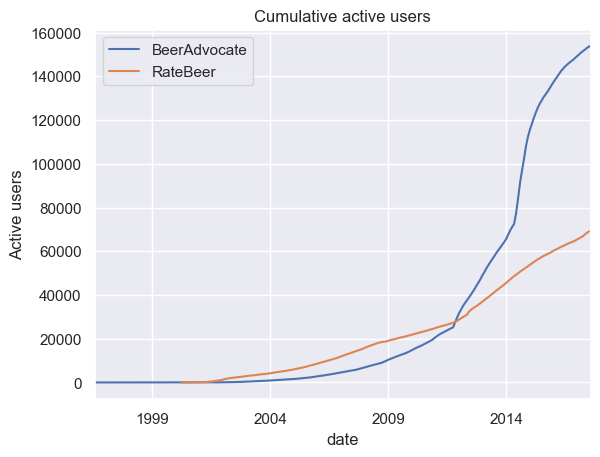

In [6]:
plt.title("Cumulative active users")
plt.xlabel("Month")
plt.ylabel("Active users")
pd.to_datetime(
    df_ba_ratings.sort_values(["date"]).groupby("user_id")["date"].first(), unit="s"
).dt.to_period("M").value_counts().sort_index().cumsum().plot(label="BeerAdvocate")
pd.to_datetime(
    df_rb_ratings.sort_values(["date"]).groupby("user_id")["date"].first(), unit="s"
).dt.to_period("M").value_counts().sort_index().cumsum().plot(label="RateBeer")
plt.legend()

<Axes: title={'center': 'Cumulative ratings count'}, xlabel='month', ylabel='Cumulative ratings count'>

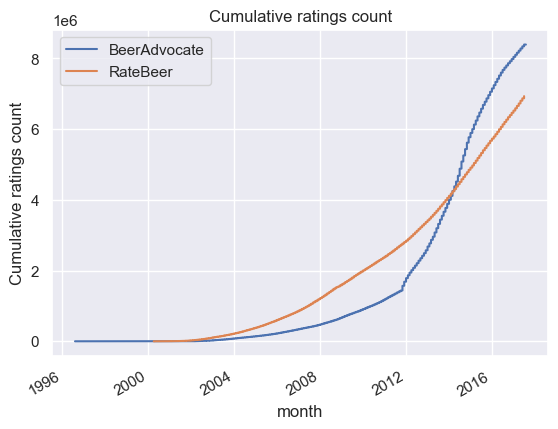

In [7]:
fig, ax = plt.subplots()
plt.title("Cumulative ratings count")
plt.xlabel("Month")
plt.ylabel("Cumulative ratings count")
compute_cumulative_ratings_count(df_ba_ratings).plot(
    x="month", y="cumulative_ratings_count", label="BeerAdvocate", ax=ax
)
compute_cumulative_ratings_count(df_rb_ratings).plot(
    x="month", y="cumulative_ratings_count", label="RateBeer", ax=ax
)

In [8]:
df_ba_current_beer_per_style = number_of_beer_per_style(df_ba_ratings)
df_rb_current_beer_per_style = number_of_beer_per_style(df_rb_ratings)

df_ba_ratings, df_ba_user_beer_style_past_ratings = remove_before_month(
    df_ba_ratings, df_ba_user_beer_style_past_ratings, "2004-01"
)
df_rb_ratings, df_rb_user_beer_style_past_ratings = remove_before_month(
    df_rb_ratings, df_rb_user_beer_style_past_ratings, "2004-01"
)

# 3. Beer Advocate vs Rate Beer

# 4. Expert

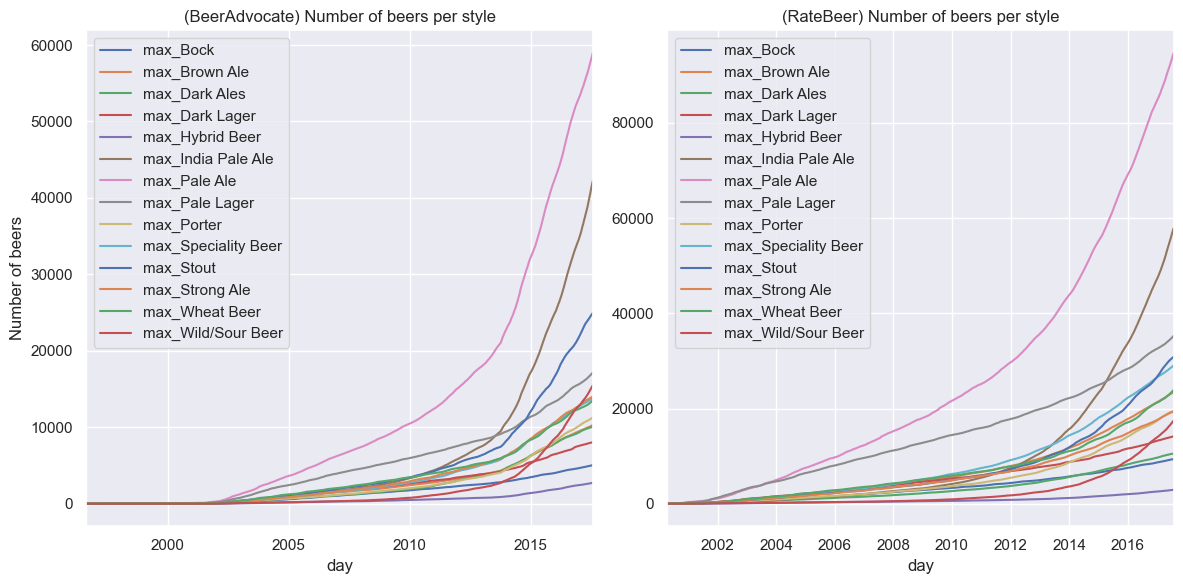

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.ravel()

axs[0].set_title("(BeerAdvocate) Number of beers per style")
axs[1].set_title("(RateBeer) Number of beers per style")
axs[0].set_xlabel("Day")
axs[1].set_xlabel("Day")
axs[0].set_ylabel("Number of beers")

df_ba_current_beer_per_style.plot(x="day", ax=axs[0])
df_rb_current_beer_per_style.plot(x="day", ax=axs[1])

plt.tight_layout()
plt.show()

In [10]:
(
    df_ba_user_beer_style_past_ratings,
    df_ba_knowledge,
    df_ba_local_knowledge,
    ba_max_columns,
) = add_all_knowledge(df_ba_user_beer_style_past_ratings, df_ba_current_beer_per_style)

/Users/martinlebras/Documents/Cours/EPFL/Projets/ada-2024-project-pdfromscratch/src/utils/beer_knowledge.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_knowledge.loc[:,"knowledge"] = (df_knowledge["global_knowledge"] + df_knowledge["local_knowledge"]) / 2


In [11]:
(
    df_rb_user_beer_style_past_ratings,
    df_rb_knowledge,
    df_rb_local_knowledge,
    rb_max_columns,
) = add_all_knowledge(df_rb_user_beer_style_past_ratings, df_rb_current_beer_per_style)

/Users/martinlebras/Documents/Cours/EPFL/Projets/ada-2024-project-pdfromscratch/src/utils/beer_knowledge.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_knowledge.loc[:,"knowledge"] = (df_knowledge["global_knowledge"] + df_knowledge["local_knowledge"]) / 2


In [12]:
df_ba_prime_knowledge = (
    df_ba_knowledge[["user_id", "global_knowledge", "local_knowledge", "knowledge"]]
    .groupby("user_id")
    .max()
    .reset_index()
)
df_rb_prime_knowledge = (
    df_rb_knowledge[["user_id", "global_knowledge", "local_knowledge", "knowledge"]]
    .groupby("user_id")
    .max()
    .reset_index()
)

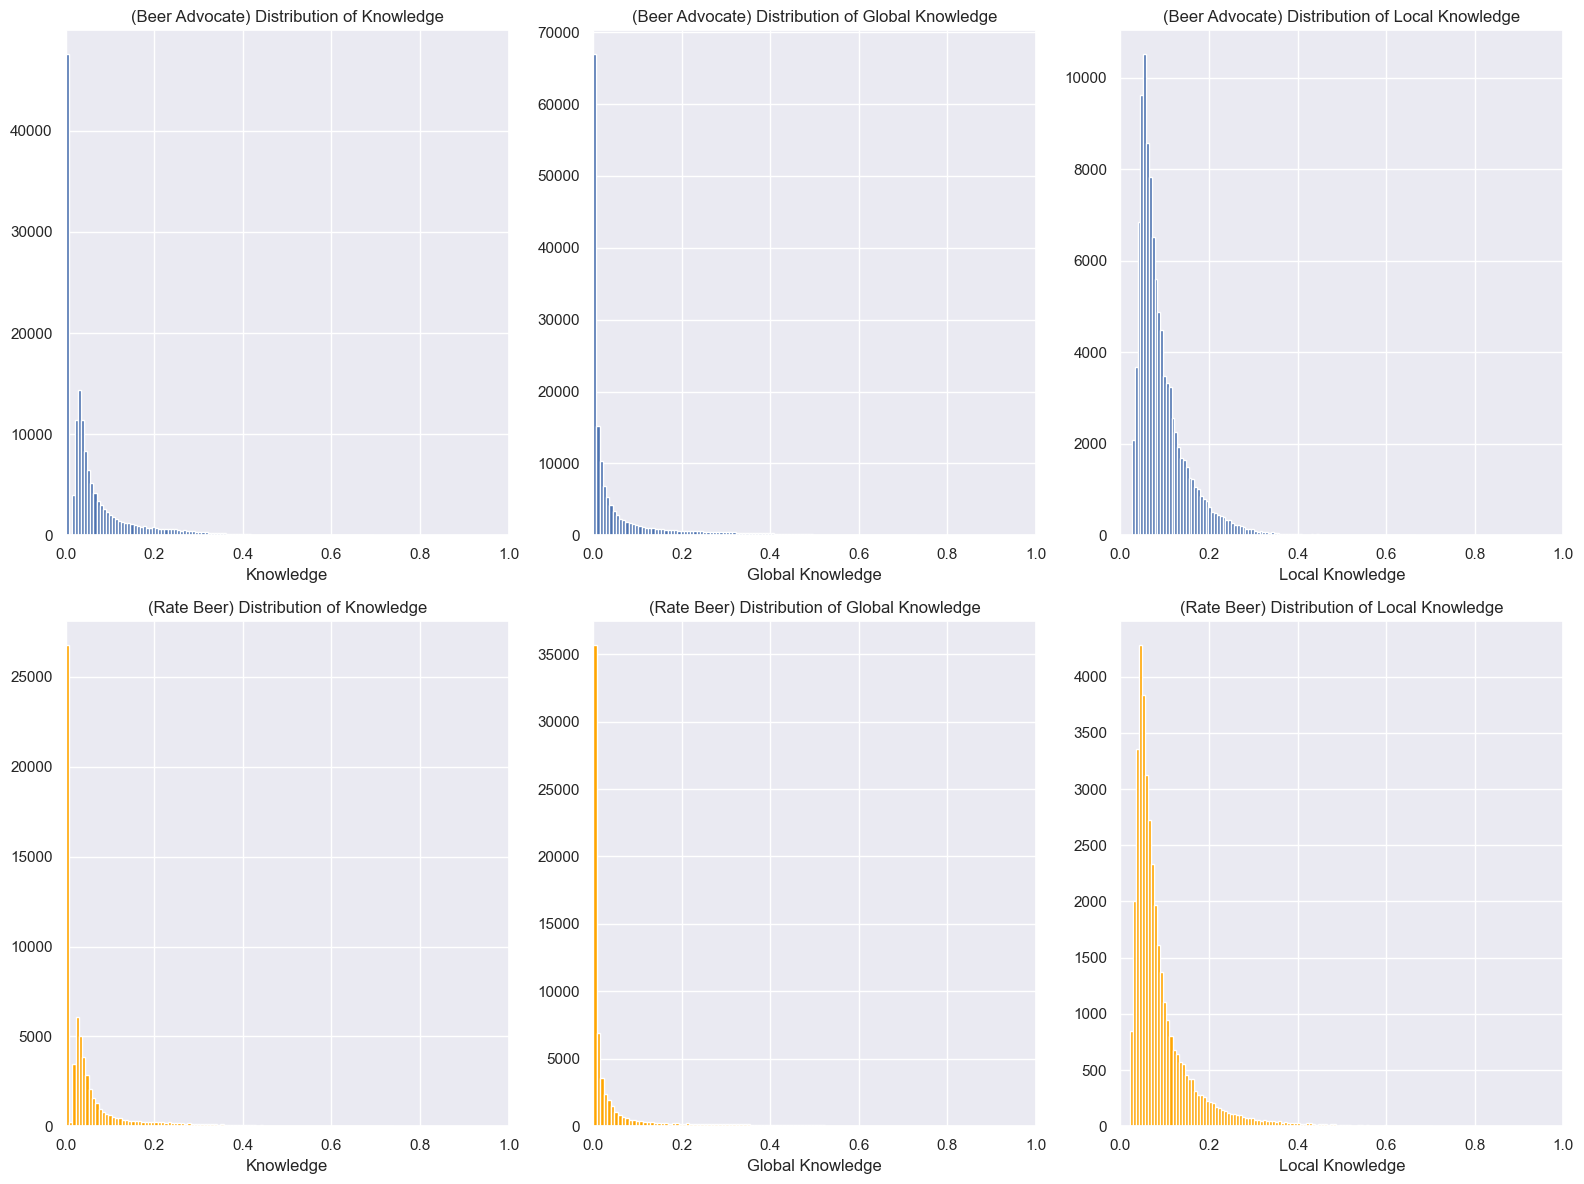

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(16, 12))
axs = axs.ravel()

axs[0].set_title("(Beer Advocate) Distribution of Knowledge")
axs[0].set_xlabel("Knowledge")
axs[0].set_xlim([0, 1])

axs[1].set_title("(Beer Advocate) Distribution of Global Knowledge")
axs[1].set_xlabel("Global Knowledge")
axs[1].set_xlim([0, 1])

axs[2].set_title("(Beer Advocate) Distribution of Local Knowledge")
axs[2].set_xlabel("Local Knowledge")
axs[2].set_xlim([0, 1])

axs[3].set_title("(Rate Beer) Distribution of Knowledge")
axs[3].set_xlabel("Knowledge")
axs[3].set_xlim([0, 1])

axs[4].set_title("(Rate Beer) Distribution of Global Knowledge")
axs[4].set_xlabel("Global Knowledge")
axs[4].set_xlim([0, 1])

axs[5].set_title("(Rate Beer) Distribution of Local Knowledge")
axs[5].set_xlabel("Local Knowledge")
axs[5].set_xlim([0, 1])

df_ba_prime_knowledge["knowledge"].hist(bins=100, ax=axs[0])
df_ba_prime_knowledge["global_knowledge"].hist(bins=100, ax=axs[1])
df_ba_prime_knowledge["local_knowledge"].hist(bins=100, ax=axs[2])

df_rb_prime_knowledge["knowledge"].hist(bins=100, ax=axs[3], color="orange")
df_rb_prime_knowledge["global_knowledge"].hist(bins=100, ax=axs[4], color="orange")
df_rb_prime_knowledge["local_knowledge"].hist(bins=100, ax=axs[5], color="orange")

plt.tight_layout()
plt.show()

In [14]:
# Save memory
del df_ba_prime_knowledge
del df_rb_prime_knowledge

In [15]:
df_ba_highest_global_knowledge = df_ba_knowledge.loc[
    df_ba_knowledge[["user_id", "global_knowledge"]]
    .groupby("user_id")
    .idxmax()
    .reset_index()["global_knowledge"]
]
df_rb_highest_global_knowledge = df_rb_knowledge.loc[
    df_rb_knowledge[["user_id", "global_knowledge"]]
    .groupby("user_id")
    .idxmax()
    .reset_index()["global_knowledge"]
]

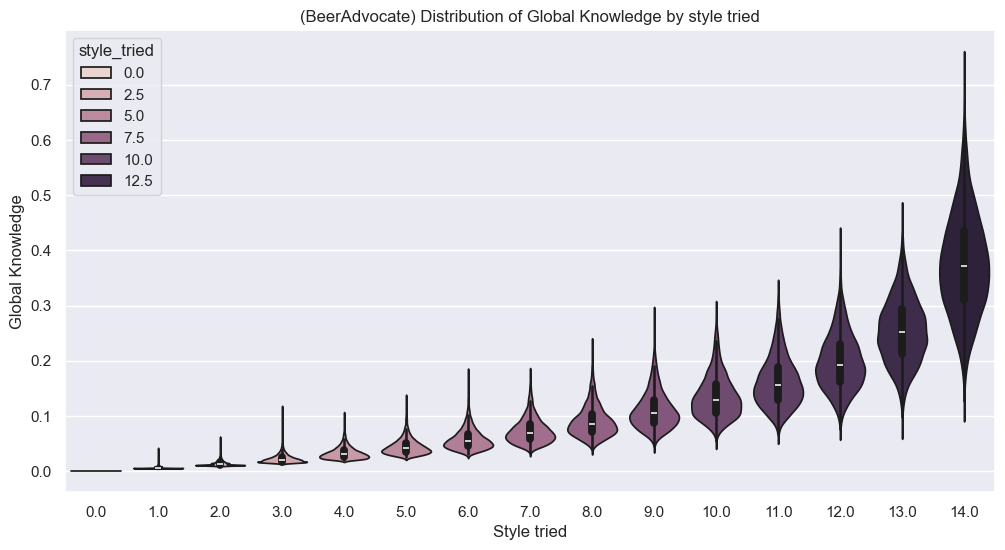

In [16]:
plt.figure(figsize=(12, 6))
plt.title("(BeerAdvocate) Distribution of Global Knowledge by style tried")
plt.xlabel("Style tried")
plt.ylabel("Global Knowledge")
sns.violinplot(
    x=df_ba_highest_global_knowledge["style_tried"],
    y=df_ba_highest_global_knowledge["global_knowledge"],
    hue=df_ba_highest_global_knowledge["style_tried"],
)
plt.show()

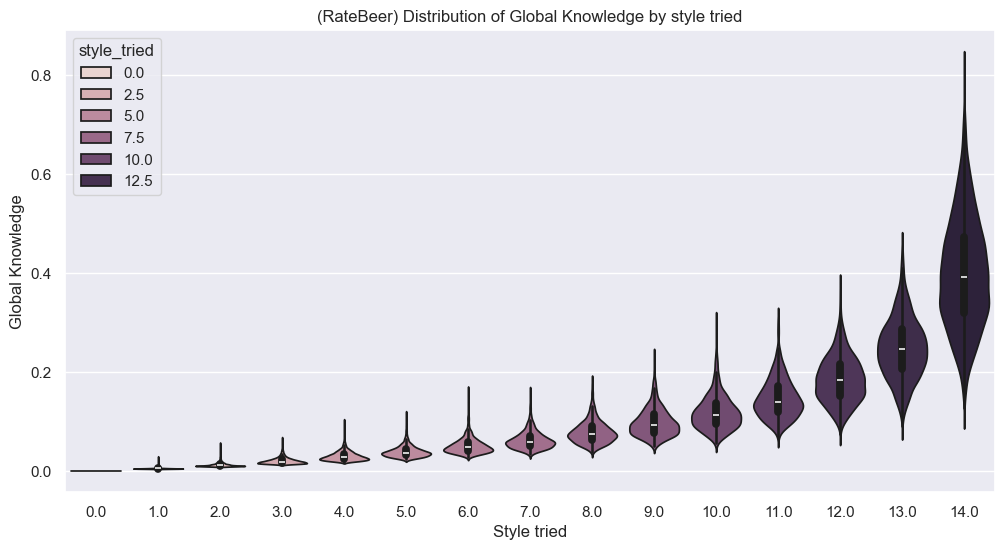

In [17]:
plt.figure(figsize=(12, 6))
plt.title("(RateBeer) Distribution of Global Knowledge by style tried")
plt.xlabel("Style tried")
plt.ylabel("Global Knowledge")
sns.violinplot(
    x=df_rb_highest_global_knowledge["style_tried"],
    y=df_rb_highest_global_knowledge["global_knowledge"],
    hue=df_rb_highest_global_knowledge["style_tried"],
)
plt.show()

In [18]:
# Save memory
del df_ba_highest_global_knowledge
del df_rb_highest_global_knowledge

### Local knowledge

In [19]:
df_ba_prime_local_knowledge = (
    df_ba_local_knowledge.iloc[:, :-2].groupby("user_id").max().reset_index()
)
df_rb_prime_local_knowledge = (
    df_rb_local_knowledge.iloc[:, :-2].groupby("user_id").max().reset_index()
)

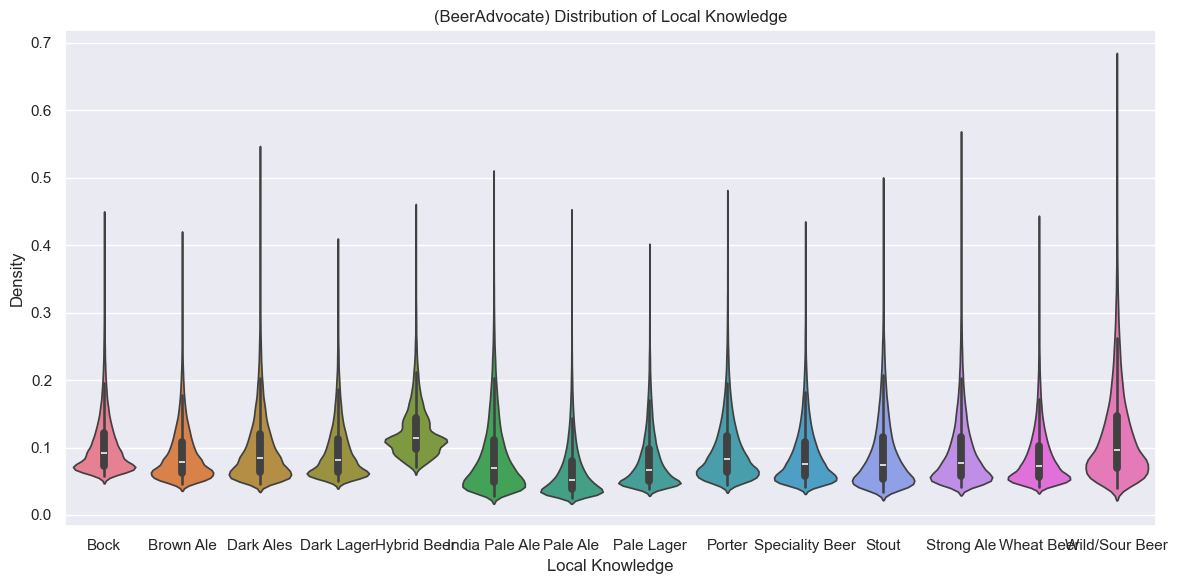

In [20]:
plt.figure(figsize=(12, 6))
plt.title("(BeerAdvocate) Distribution of Local Knowledge")
plt.xlabel("Local Knowledge")
plt.ylabel("Density")
sns.violinplot(df_ba_prime_local_knowledge.iloc[:, 1:].replace(0, np.nan))
plt.tight_layout()
plt.show()

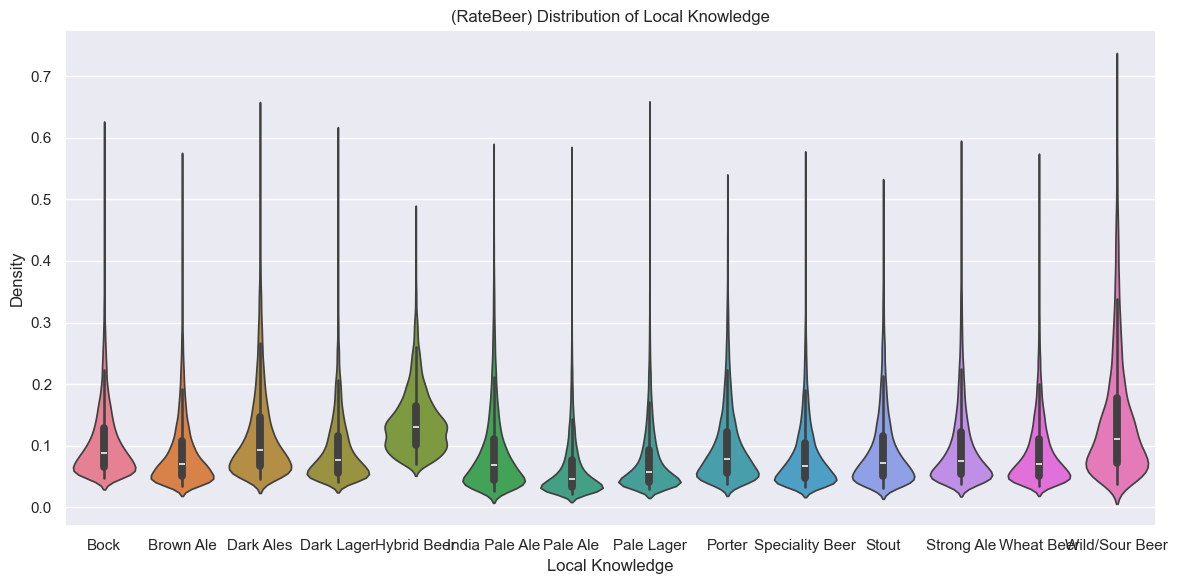

In [21]:
plt.figure(figsize=(12, 6))
plt.title("(RateBeer) Distribution of Local Knowledge")
plt.xlabel("Local Knowledge")
plt.ylabel("Density")
sns.violinplot(df_rb_prime_local_knowledge.iloc[:, 1:].replace(0, np.nan))
plt.tight_layout()
plt.show()

In [22]:
# Save memory
del df_ba_prime_local_knowledge
del df_rb_prime_local_knowledge

### Experts

In [23]:
df_ba_user_beer_style_past_ratings, df_ba_local_knowledge_quantile_expert = add_experts(
    df_ba_local_knowledge, df_ba_user_beer_style_past_ratings, 0.99
)
df_rb_user_beer_style_past_ratings, df_rb_local_knowledge_quantile_expert = add_experts(
    df_rb_local_knowledge, df_rb_user_beer_style_past_ratings, 0.99
)

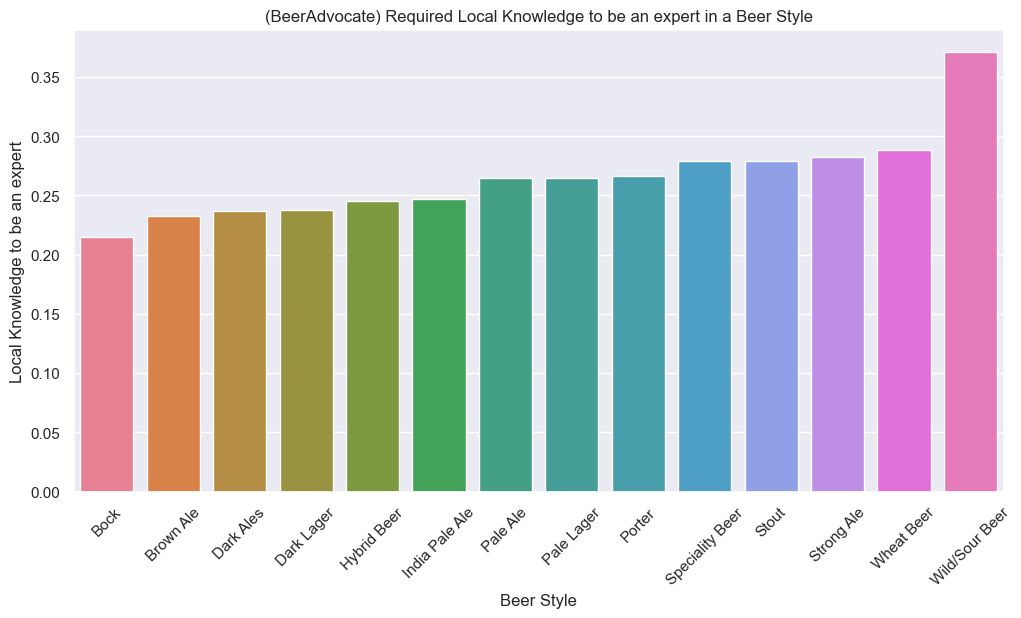

In [24]:
plt.figure(figsize=(12, 6))
plt.title("(BeerAdvocate) Required Local Knowledge to be an expert in a Beer Style")
plt.xlabel("Beer Style")
plt.ylabel("Local Knowledge to be an expert")
sns.barplot(
    x=df_ba_local_knowledge_quantile_expert.index,
    y=df_ba_local_knowledge_quantile_expert.sort_values(),
    hue=df_ba_local_knowledge_quantile_expert.index,
)
plt.xticks(rotation=45)
plt.show()

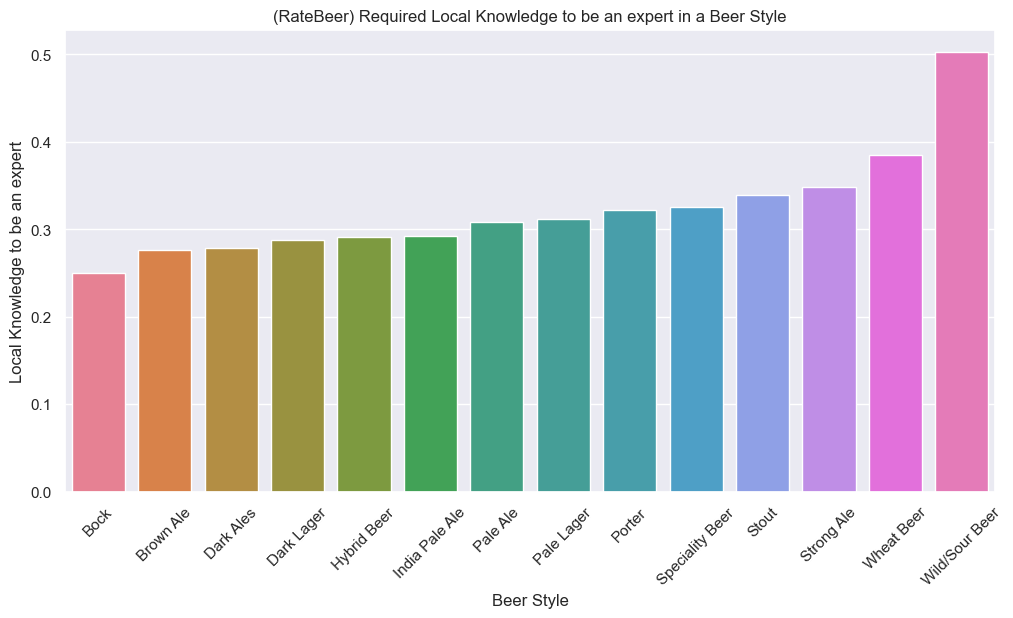

In [25]:
plt.figure(figsize=(12, 6))
plt.title("(RateBeer) Required Local Knowledge to be an expert in a Beer Style")
plt.xlabel("Beer Style")
plt.ylabel("Local Knowledge to be an expert")
sns.barplot(
    x=df_rb_local_knowledge_quantile_expert.index,
    y=df_rb_local_knowledge_quantile_expert.sort_values(),
    hue=df_rb_local_knowledge_quantile_expert.index,
)
plt.xticks(rotation=45)
plt.show()

In [27]:
df_ba_beer_required_to_be_expert_long = get_beer_required_expert(
    df_ba_user_beer_style_past_ratings,
    df_ba_local_knowledge_quantile_expert,
    ba_max_columns,
)
df_rb_beer_required_to_be_expert_long = get_beer_required_expert(
    df_rb_user_beer_style_past_ratings,
    df_rb_local_knowledge_quantile_expert,
    rb_max_columns,
)

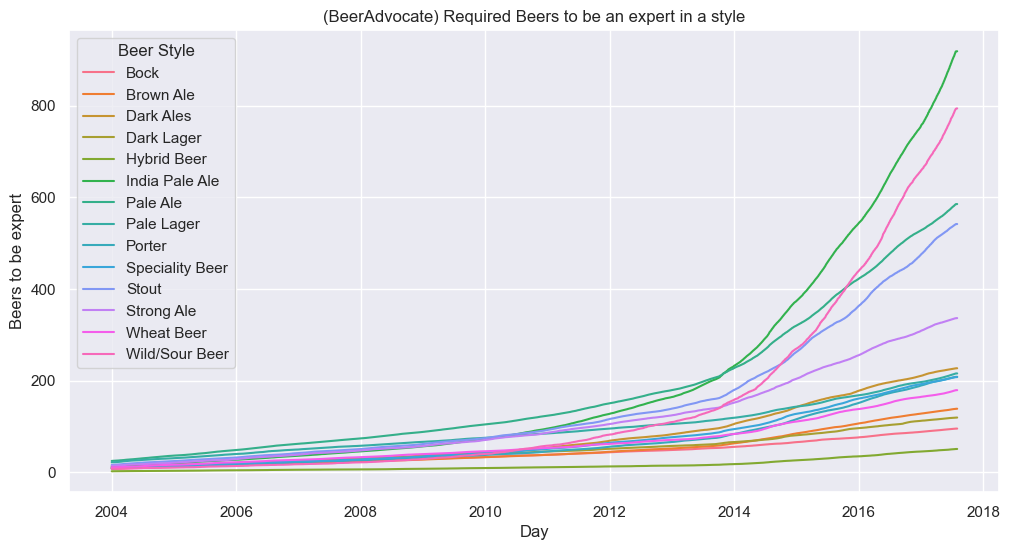

In [28]:
plt.figure(figsize=(12, 6))
plt.title("(BeerAdvocate) Required Beers to be an expert in a style")
plt.xlabel("Day")
plt.ylabel("Beers to be expert")
sns.lineplot(
    x=df_ba_beer_required_to_be_expert_long["day"],
    y=df_ba_beer_required_to_be_expert_long["Beers to be expert"],
    hue=df_ba_beer_required_to_be_expert_long["Beer Style"],
)
plt.show()

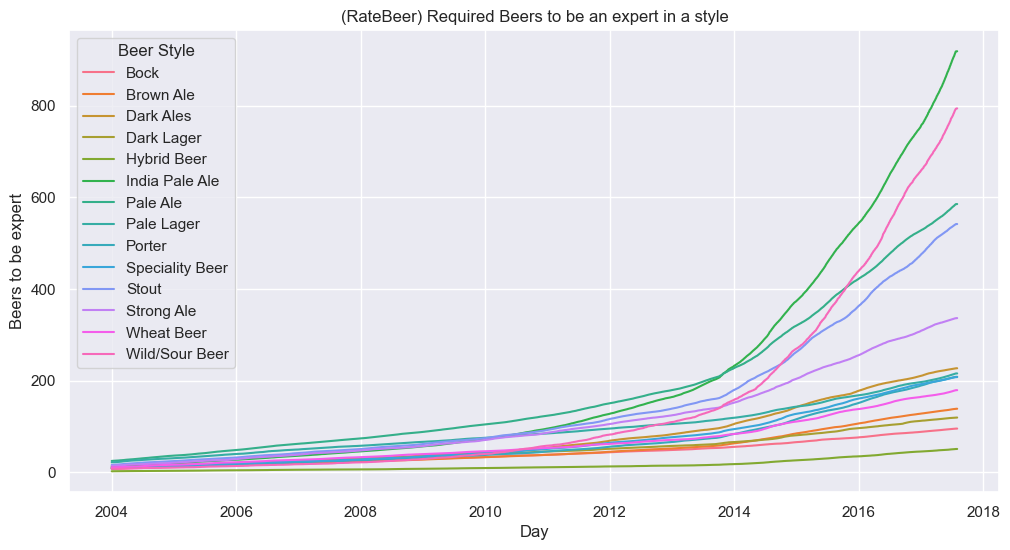

In [29]:
plt.figure(figsize=(12, 6))
plt.title("(RateBeer) Required Beers to be an expert in a style")
plt.xlabel("Day")
plt.ylabel("Beers to be expert")
sns.lineplot(
    x=df_ba_beer_required_to_be_expert_long["day"],
    y=df_ba_beer_required_to_be_expert_long["Beers to be expert"],
    hue=df_ba_beer_required_to_be_expert_long["Beer Style"],
)
plt.show()

In [ ]:
df_ba_expert_users, df_ba_count_exp, ba_expert_columns = get_expert_count(
    df_ba_user_beer_style_past_ratings, df_ba_users
)
df_rb_expert_users, df_rb_count_exp, rb_expert_columns = get_expert_count(
    df_rb_user_beer_style_past_ratings, df_rb_users
)

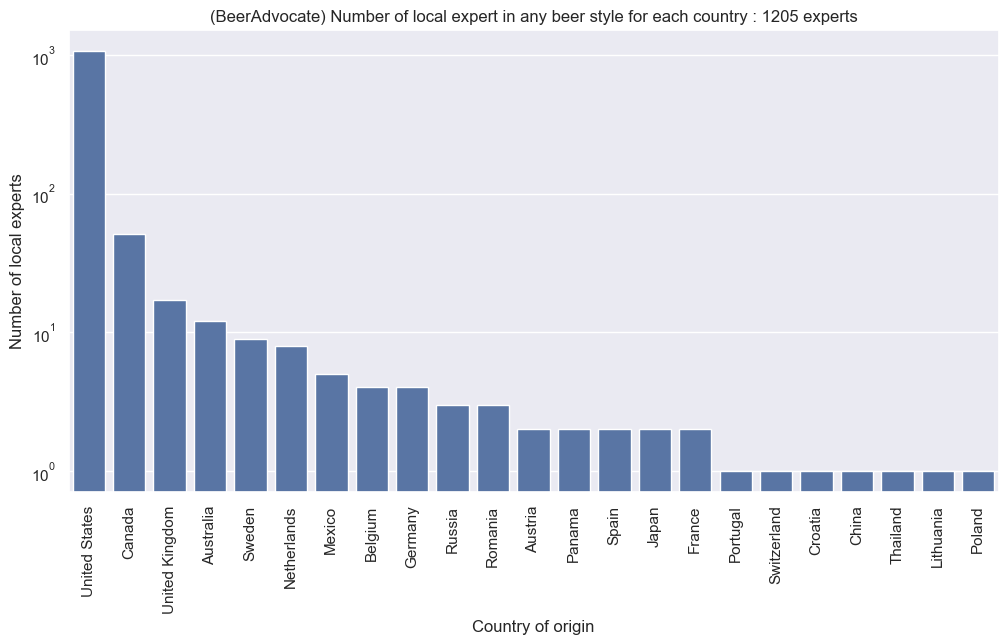

In [32]:
plt.figure(figsize=(12, 6))
sns.barplot(df_ba_expert_users["user_country"].value_counts())
plt.xticks(rotation=90)
plt.title(
    f"(BeerAdvocate) Number of local expert in any beer style for each country : {df_ba_expert_users["user_country"].value_counts().sum().item()} experts"
)
plt.xlabel("Country of origin")
plt.ylabel("Number of local experts")
plt.yscale("log")
plt.show()

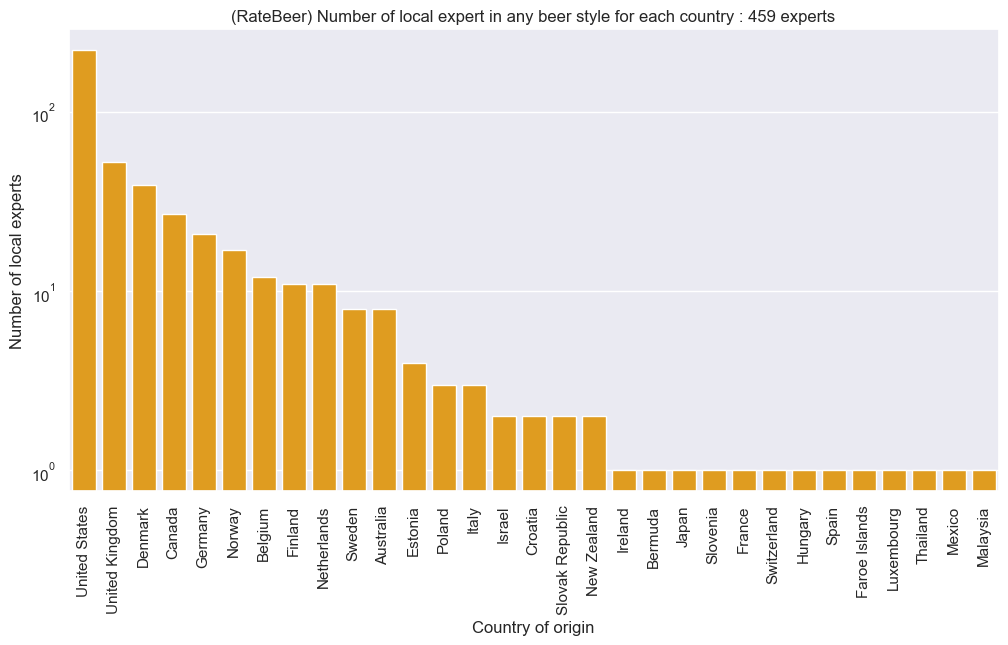

In [33]:
plt.figure(figsize=(12, 6))
sns.barplot(df_rb_expert_users["user_country"].value_counts(), color="orange")
plt.xticks(rotation=90)
plt.title(
    f"(RateBeer) Number of local expert in any beer style for each country : {df_rb_expert_users["user_country"].value_counts().sum().item()} experts"
)
plt.xlabel("Country of origin")
plt.ylabel("Number of local experts")
plt.yscale("log")
plt.show()

In [34]:
fig = px.choropleth(
    df_ba_count_exp,
    locations="user_country_code",
    color="log_count",
    hover_name="user_country_code",
    hover_data="count",
    color_continuous_scale=px.colors.sequential.Viridis,
)
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    geo=dict(showframe=False, showcoastlines=True, projection_type="mercator"),
)
fig.show()

In [35]:
fig = px.choropleth(
    df_rb_count_exp,
    locations="user_country_code",
    color="log_count",
    hover_name="user_country_code",
    hover_data="count",
    color_continuous_scale=px.colors.sequential.Viridis,
)

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    geo=dict(showframe=False, showcoastlines=True, projection_type="mercator"),
)
fig.show()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_52765/3468930848.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_52765/3468930848.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_52765/3468930848.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_52765/3468930848.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_52765/3468930848.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number

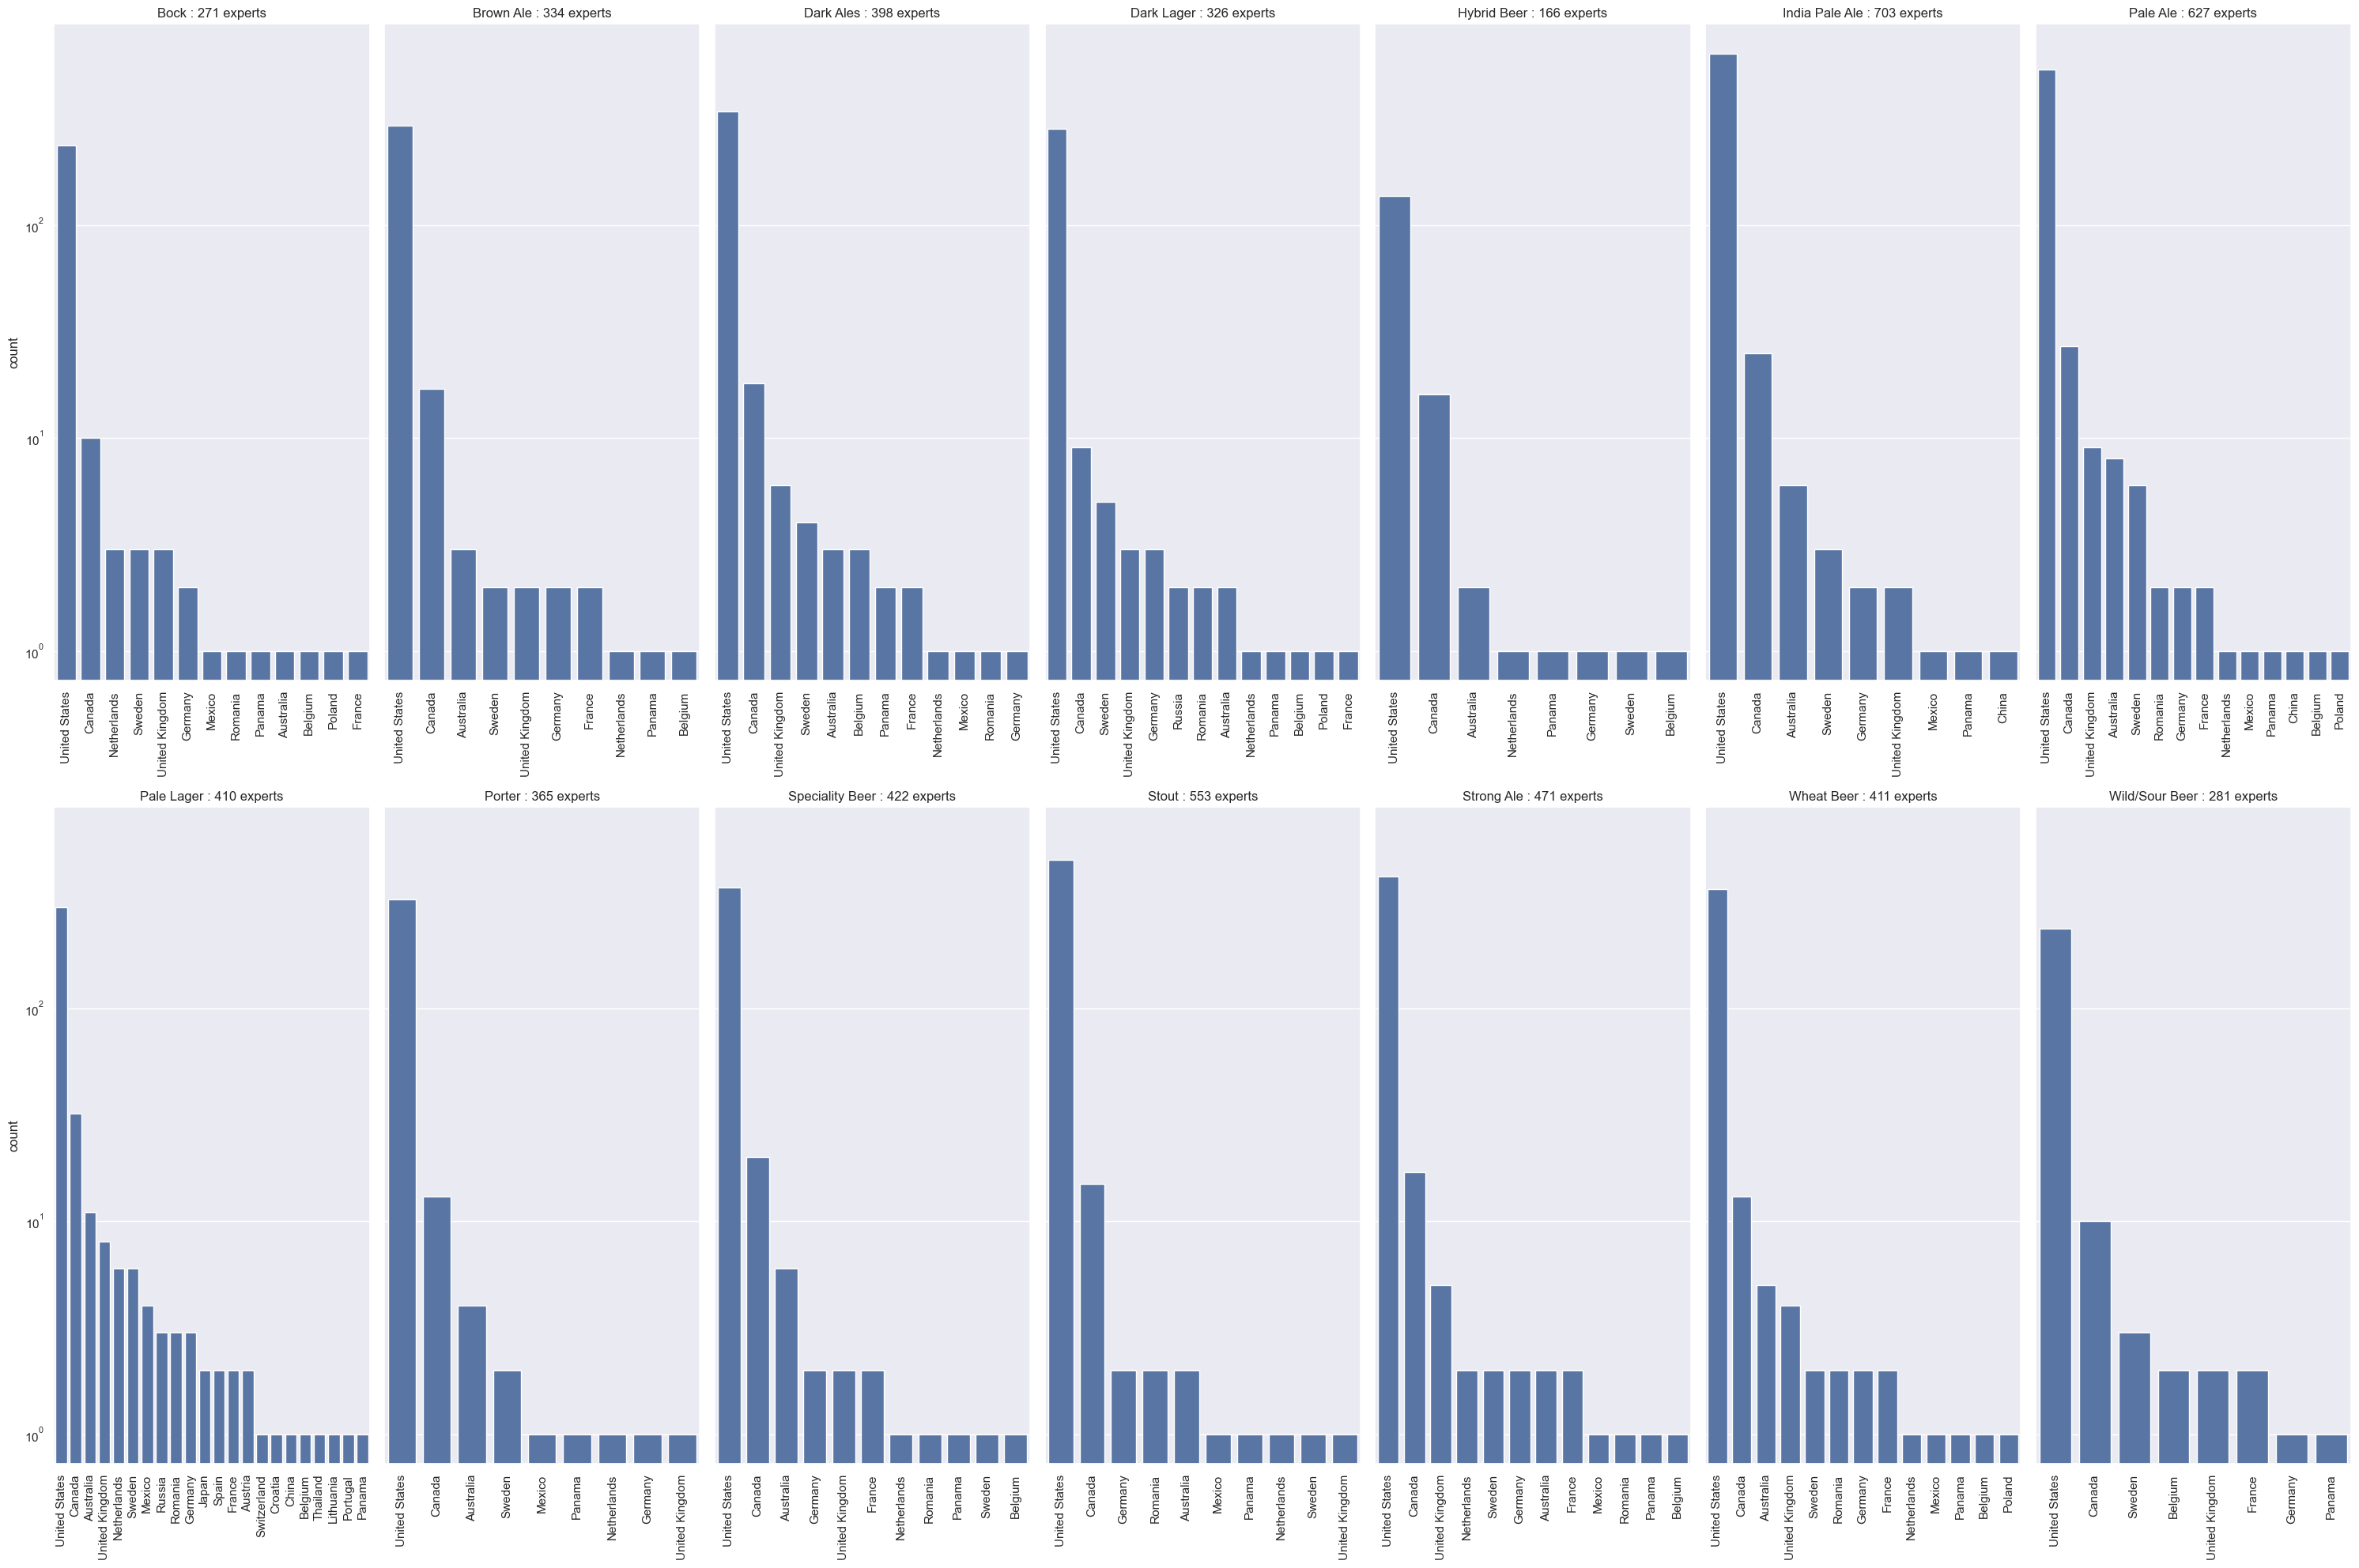

In [36]:
fig, axes = plt.subplots(2, 7, figsize=(30, 20), sharey=True)

for col_idx, col in enumerate(ba_expert_columns):
    sns.barplot(
        df_ba_expert_users[df_ba_expert_users[col] == 1]["user_country"].value_counts(),
        ax=axes[col_idx // 7, col_idx % 7],
    )
    # axes[col_idx//7,col_idx%7].set_xticklabels(rotation=90)
    axes[col_idx // 7, col_idx % 7].set_xticklabels(
        axes[col_idx // 7, col_idx % 7].get_xticklabels(), rotation=90
    )
    axes[col_idx // 7, col_idx % 7].set_xlabel("")
    # plt.ylabel(f"Number of local experts in {col.split("_")[0]}")
    axes[col_idx // 7, col_idx % 7].set_title(
        f"{col.split("_")[0]} : {df_ba_expert_users[col].sum()} experts"
    )
    axes[col_idx // 7, col_idx % 7].set_yscale("log")

plt.tight_layout()
plt.show()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_52765/1591163478.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_52765/1591163478.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_52765/1591163478.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_52765/1591163478.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_52765/1591163478.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number

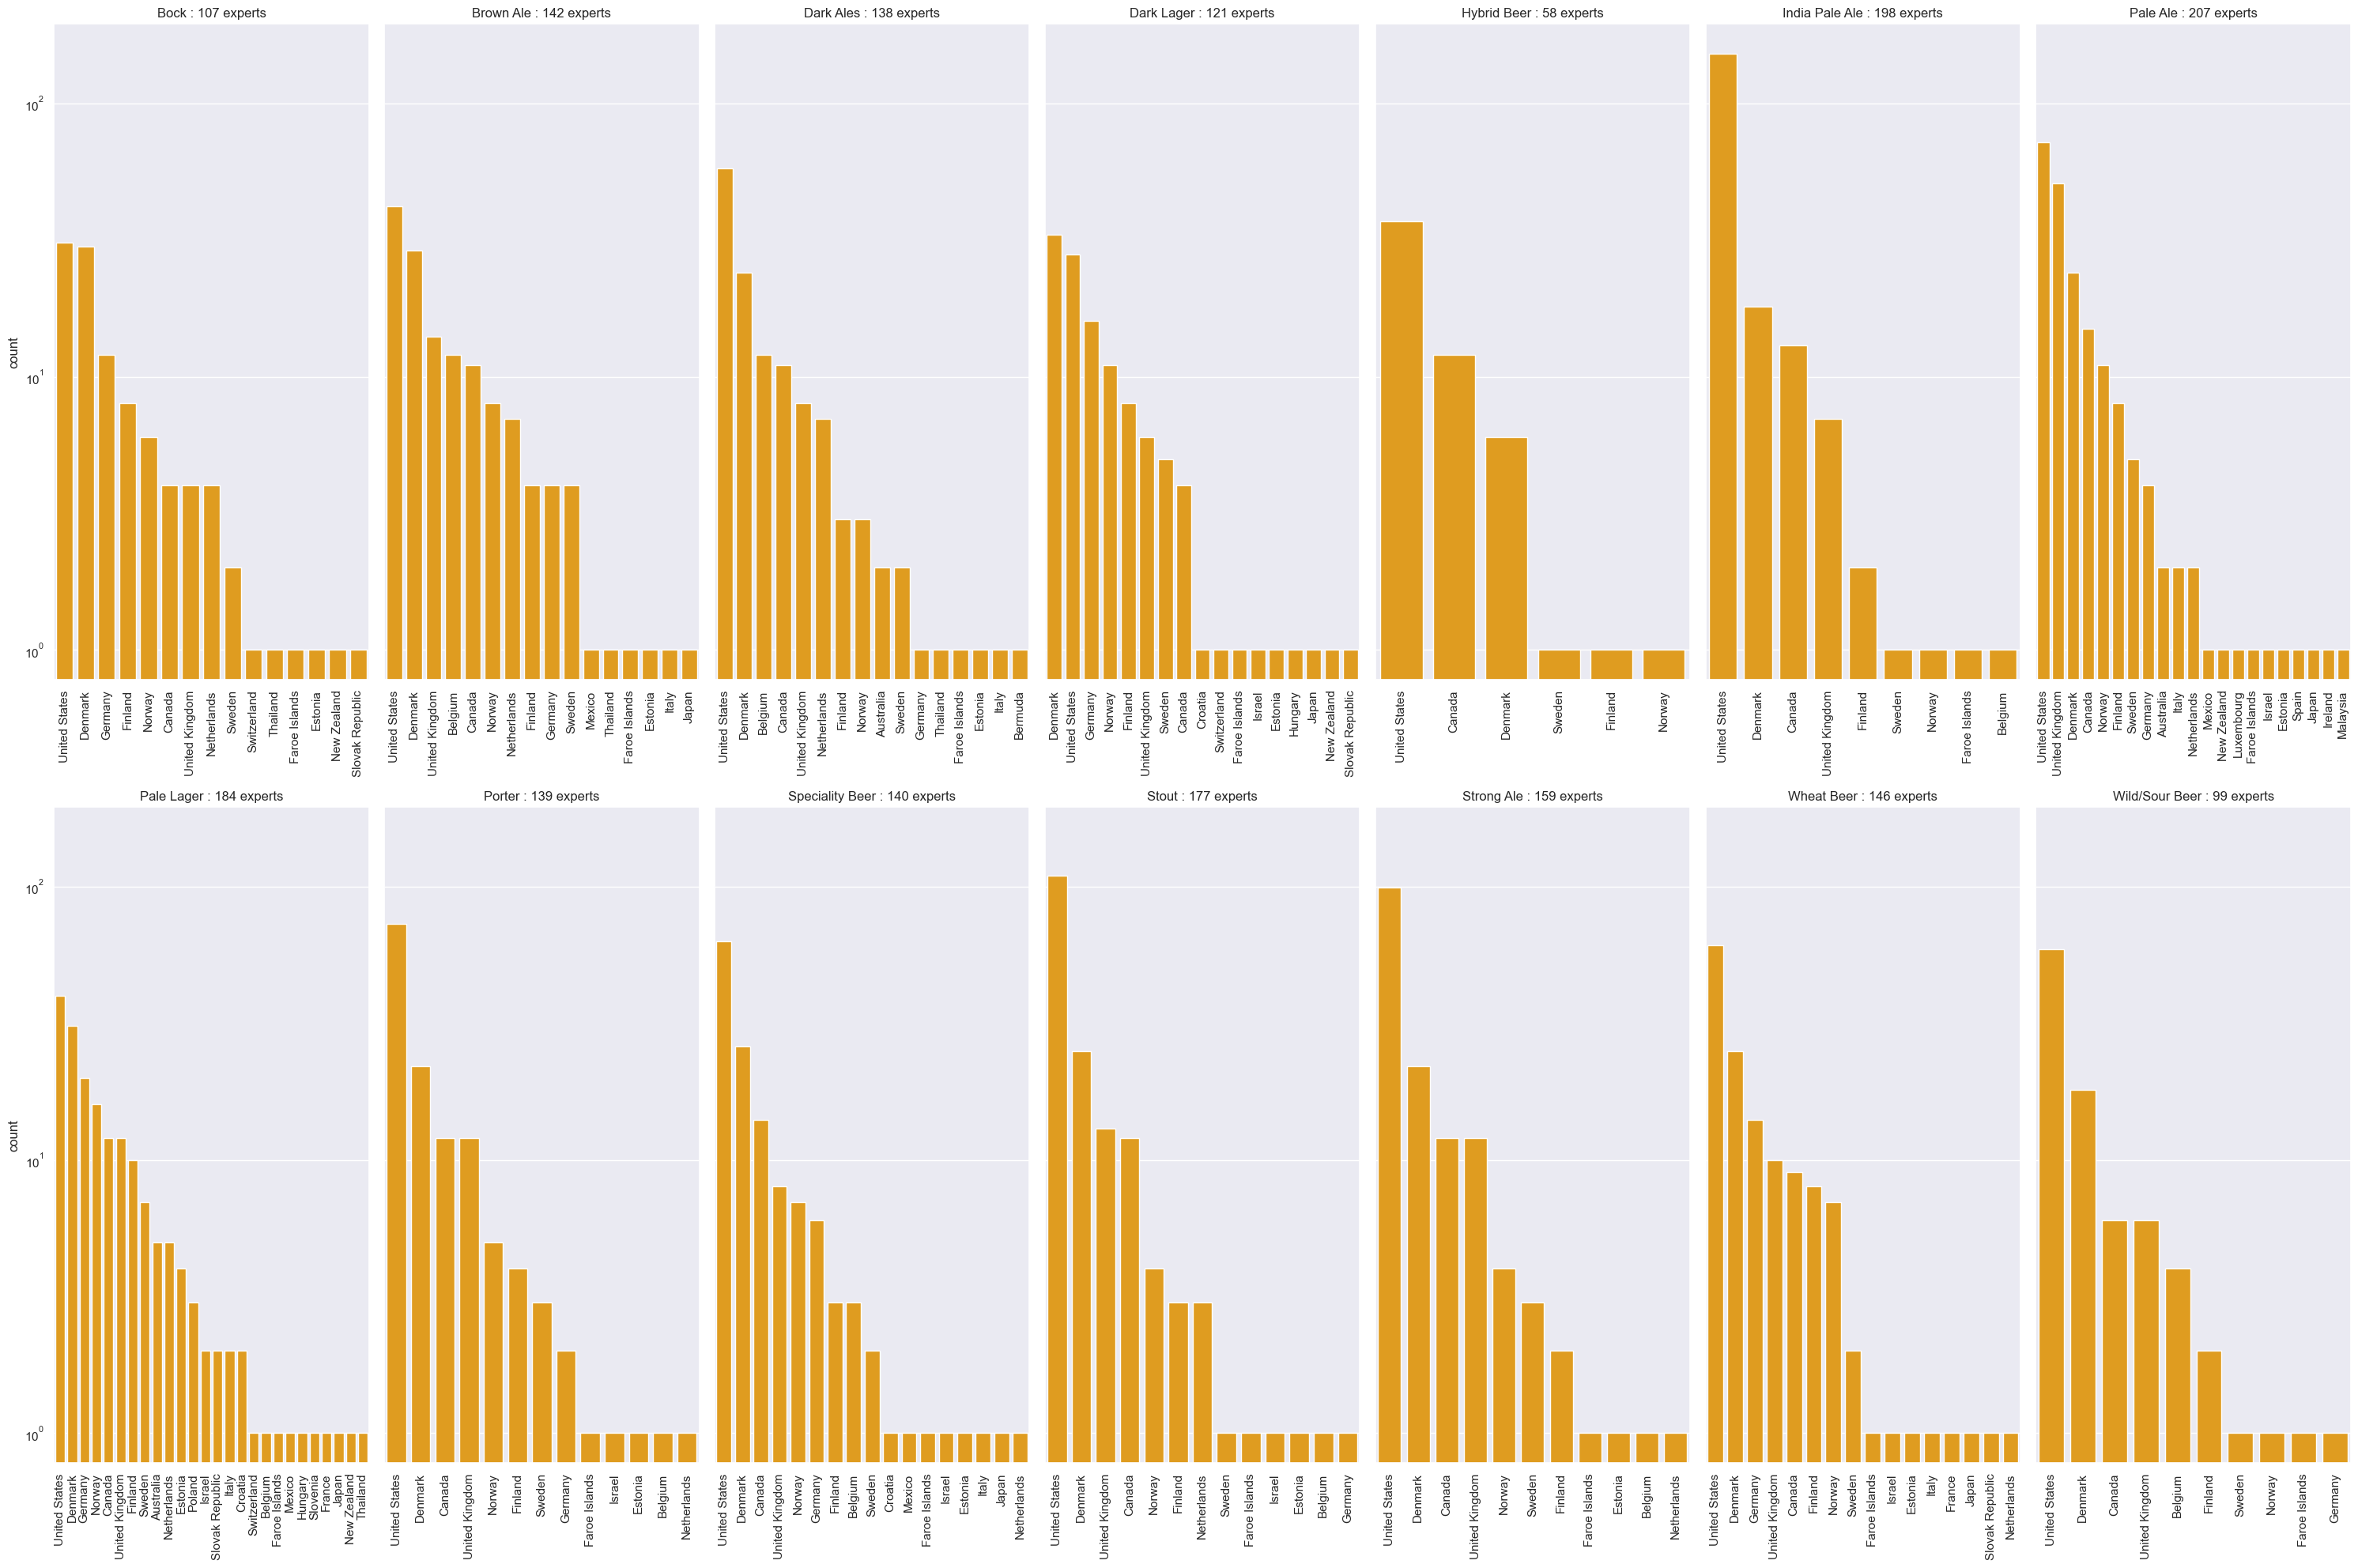

In [37]:
fig, axes = plt.subplots(2, 7, figsize=(30, 20), sharey=True)

for col_idx, col in enumerate(rb_expert_columns):
    sns.barplot(
        df_rb_expert_users[df_rb_expert_users[col] == 1]["user_country"].value_counts(),
        ax=axes[col_idx // 7, col_idx % 7],
        color="orange",
    )
    # axes[col_idx//7,col_idx%7].set_xticklabels(rotation=90)
    axes[col_idx // 7, col_idx % 7].set_xticklabels(
        axes[col_idx // 7, col_idx % 7].get_xticklabels(), rotation=90
    )
    axes[col_idx // 7, col_idx % 7].set_xlabel("")
    # plt.ylabel(f"Number of local experts in {col.split("_")[0]}")
    axes[col_idx // 7, col_idx % 7].set_title(
        f"{col.split("_")[0]} : {df_rb_expert_users[col].sum()} experts"
    )
    axes[col_idx // 7, col_idx % 7].set_yscale("log")

plt.tight_layout()
plt.show()

In [38]:
df_ba_expert_per_day = (
    df_ba_user_beer_style_past_ratings[ba_expert_columns + ["month", "user_id"]]
    .groupby(["user_id", "month"])
    .max()
    .reset_index()
    .iloc[:, 1:]
    .groupby("month")
    .sum()
    .reset_index()
)
df_ba_expert_per_day_long = df_ba_expert_per_day.melt(
    id_vars="month", var_name="Beer Style", value_name="Number of expert ratings"
)

df_rb_expert_per_day = (
    df_rb_user_beer_style_past_ratings[rb_expert_columns + ["month", "user_id"]]
    .groupby(["user_id", "month"])
    .max()
    .reset_index()
    .iloc[:, 1:]
    .groupby("month")
    .sum()
    .reset_index()
)
df_rb_expert_per_day_long = df_rb_expert_per_day.melt(
    id_vars="month", var_name="Beer Style", value_name="Number of expert ratings"
)

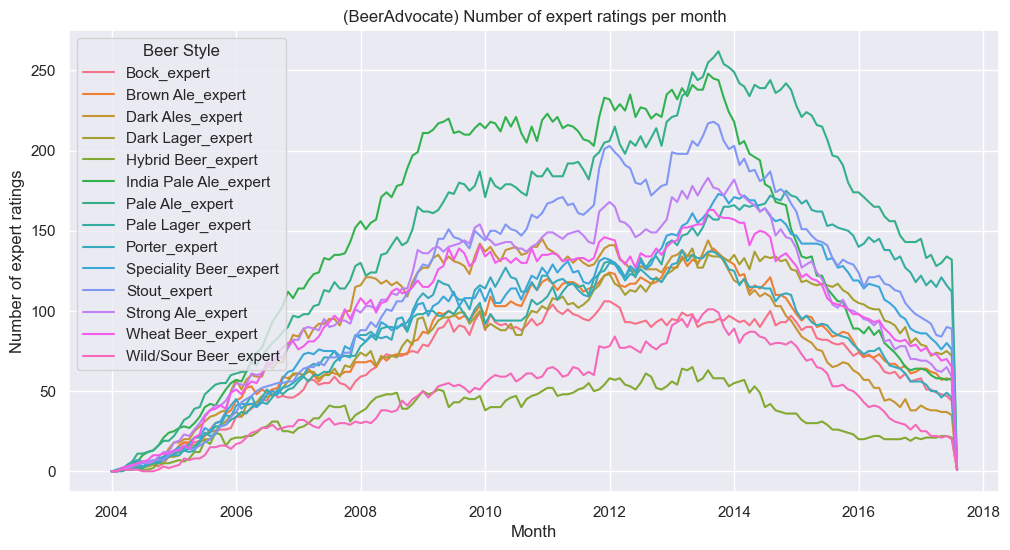

In [39]:
plt.figure(figsize=(12, 6))
plt.title("(BeerAdvocate) Number of expert ratings per month")
plt.xlabel("Month")
plt.ylabel("Number of expert ratings")
sns.lineplot(
    data=df_ba_expert_per_day_long,
    x="month",
    y="Number of expert ratings",
    hue="Beer Style",
)
plt.show()

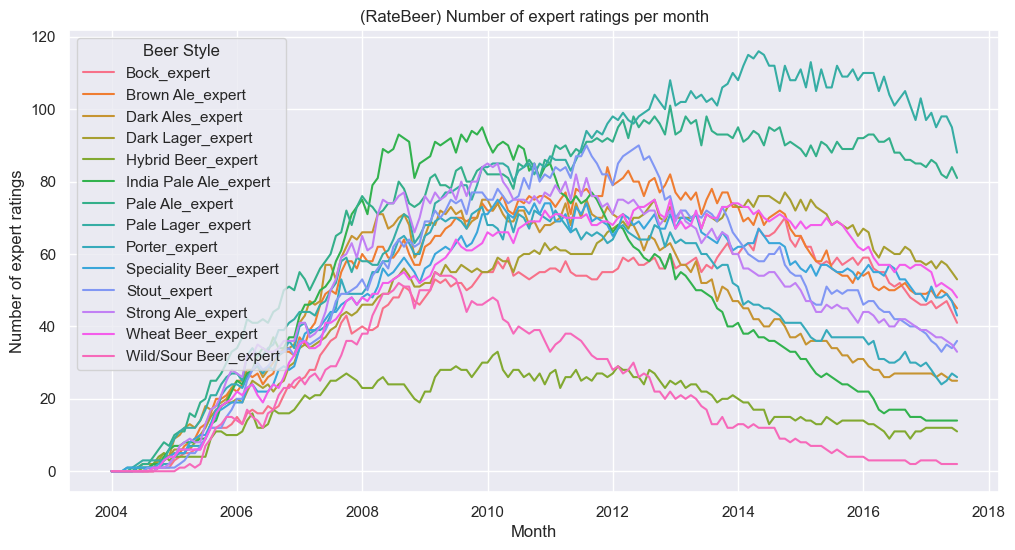

In [40]:
plt.figure(figsize=(12, 6))
plt.title("(RateBeer) Number of expert ratings per month")
plt.xlabel("Month")
plt.ylabel("Number of expert ratings")
sns.lineplot(
    data=df_rb_expert_per_day_long,
    x="month",
    y="Number of expert ratings",
    hue="Beer Style",
)
plt.show()

In [ ]:
df_ba_to_barplot = get_mean_expert_vs_non(
    df_ba_ratings, df_ba_user_beer_style_past_ratings, ba_expert_columns, k=100
)
df_rb_to_rbrplot = get_mean_expert_vs_non(
    df_rb_ratings, df_rb_user_beer_style_past_ratings, rb_expert_columns, k=100
)

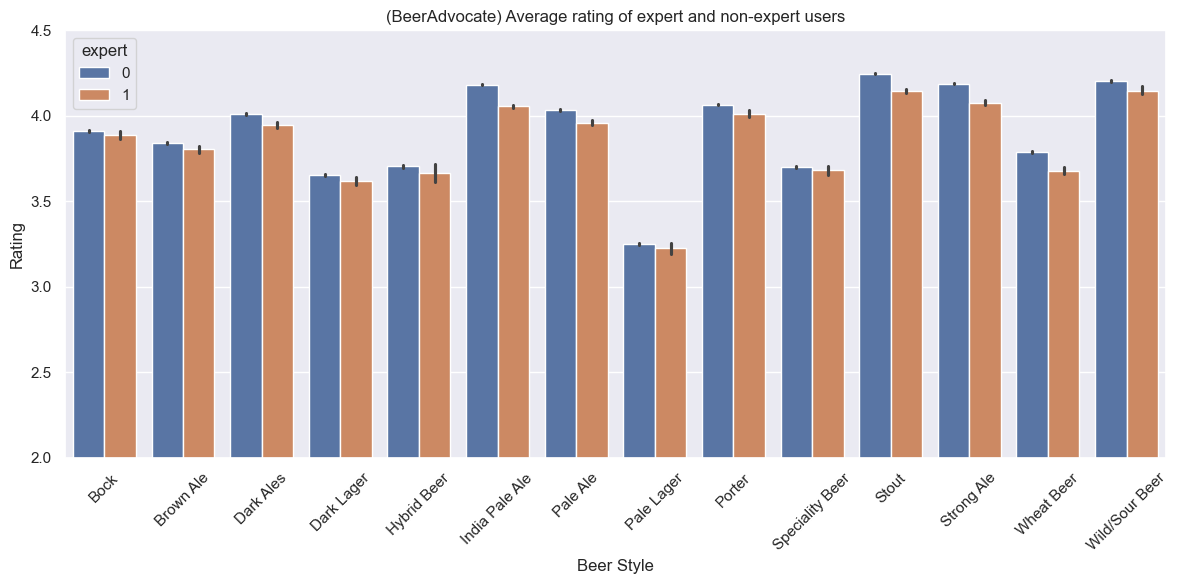

In [43]:
plt.figure(figsize=(12, 6))
plt.title("(BeerAdvocate) Average rating of expert and non-expert users")
plt.xlabel("Beer Style")
plt.ylabel("Rating")
sns.barplot(data=df_ba_to_barplot, x="beer_global_style", y="rating", hue="expert")
plt.xticks(rotation=45)
plt.ylim([2, 4.5])
plt.tight_layout()
plt.show()

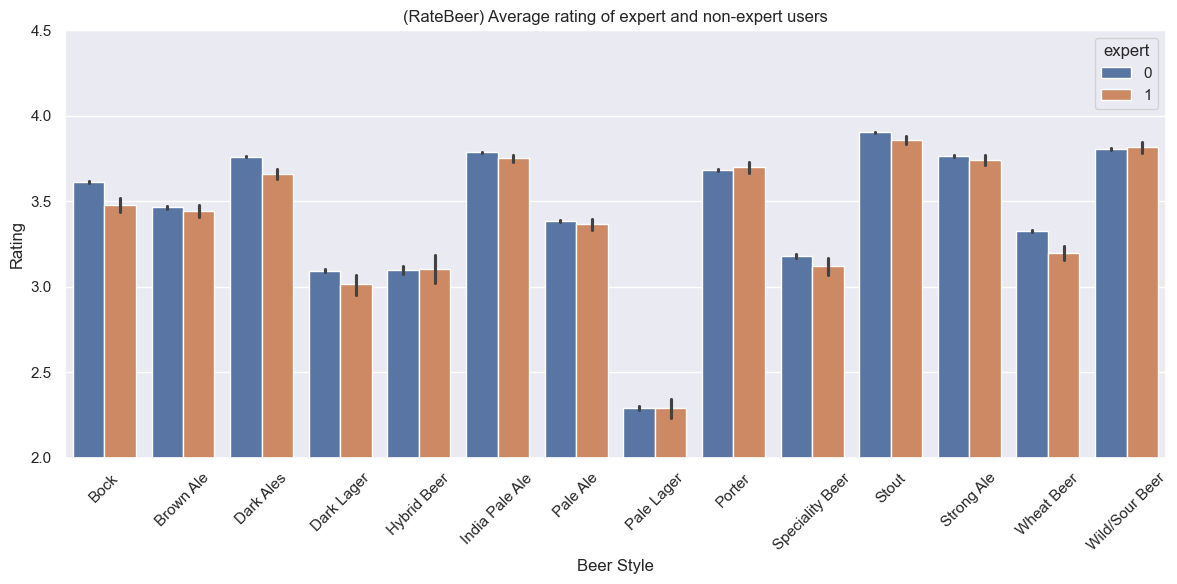

In [44]:
plt.figure(figsize=(12, 6))
plt.title("(RateBeer) Average rating of expert and non-expert users")
plt.xlabel("Beer Style")
plt.ylabel("Rating")
sns.barplot(data=df_rb_to_barplot, x="beer_global_style", y="rating", hue="expert")
plt.xticks(rotation=45)
plt.ylim([2, 4.5])
plt.tight_layout()
plt.show()

# 5. NLP Ratings

In [59]:
df_regions = pd.read_csv("src/data/regions.csv")

In [60]:
df_ba_nlp = pd.read_csv("src/data/beer_advocate/nlp_predictions.csv", index_col=0)
df_rb_nlp = pd.read_csv("src/data/rate_beer/nlp_predictions.csv", index_col=0)

In [61]:
df_ba_users = df_ba_users.merge(
    df_regions, left_on="user_country_code", right_on="ISO3", how="left"
).drop(columns=["ISO3"])
df_ba_users = df_ba_users.rename(columns={"region": "user_country_region"})
df_ba_ratings = df_ba_ratings.merge(df_ba_nlp, left_index=True, right_index=True)
df_ba_ratings = df_ba_ratings.merge(df_ba_users, on="user_id")

df_rb_users = df_rb_users.merge(
    df_regions, left_on="user_country_code", right_on="ISO3", how="left"
).drop(columns=["ISO3"])
df_rb_users = df_rb_users.rename(columns={"region": "user_country_region"})
df_rb_ratings = df_rb_ratings.merge(df_rb_nlp, left_index=True, right_index=True)
df_rb_ratings = df_rb_ratings.merge(df_rb_users, on="user_id")

In [62]:
df_ba_ratings["rating_relative_error"] = (
    df_ba_ratings["rating"] - df_ba_ratings["nlp_weighted_rating"]
) / df_ba_ratings["nlp_weighted_rating"]
df_ba_ratings["rating_absolute_error"] = (
    df_ba_ratings["rating"] - df_ba_ratings["nlp_weighted_rating"]
)

df_rb_ratings["rating_relative_error"] = (
    df_rb_ratings["rating"] - df_rb_ratings["nlp_weighted_rating"]
) / df_rb_ratings["nlp_weighted_rating"]
df_rb_ratings["rating_absolute_error"] = (
    df_rb_ratings["rating"] - df_rb_ratings["nlp_weighted_rating"]
)

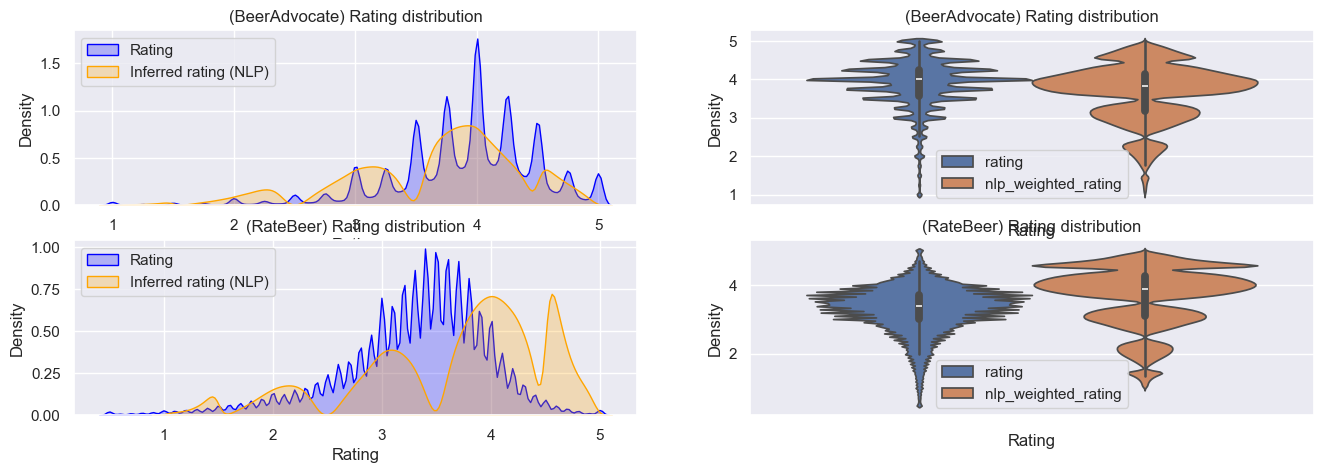

In [63]:
fig, axs = plt.subplots(2, 2, figsize=(16, 5))
axs = axs.ravel()

axs[0].set_title("(BeerAdvocate) Rating distribution")
axs[0].set_xlabel("Rating")
axs[0].set_ylabel("Density")
sns.kdeplot(df_ba_ratings["rating"], label="Rating", fill=True, color="blue", ax=axs[0])
sns.kdeplot(
    df_ba_ratings["nlp_weighted_rating"],
    label="Inferred rating (NLP)",
    fill=True,
    color="orange",
    ax=axs[0],
)
axs[0].legend()

axs[1].set_title("(BeerAdvocate) Rating distribution")
axs[1].set_xlabel("Rating")
axs[1].set_ylabel("Density")
sns.violinplot(
    df_ba_ratings.melt(
        id_vars=["user_id", "beer_id"], value_vars=["rating", "nlp_weighted_rating"]
    ),
    hue="variable",
    y="value",
    ax=axs[1],
)
axs[1].legend()

axs[2].set_title("(RateBeer) Rating distribution")
axs[2].set_xlabel("Rating")
axs[2].set_ylabel("Density")
sns.kdeplot(df_rb_ratings["rating"], label="Rating", fill=True, color="blue", ax=axs[2])
sns.kdeplot(
    df_rb_ratings["nlp_weighted_rating"],
    label="Inferred rating (NLP)",
    fill=True,
    color="orange",
    ax=axs[2],
)
axs[2].legend()

axs[3].set_title("(RateBeer) Rating distribution")
axs[3].set_xlabel("Rating")
axs[3].set_ylabel("Density")
sns.violinplot(
    df_rb_ratings.melt(
        id_vars=["user_id", "beer_id"], value_vars=["rating", "nlp_weighted_rating"]
    ),
    hue="variable",
    y="value",
    ax=axs[3],
)
axs[3].legend()

plt.show()

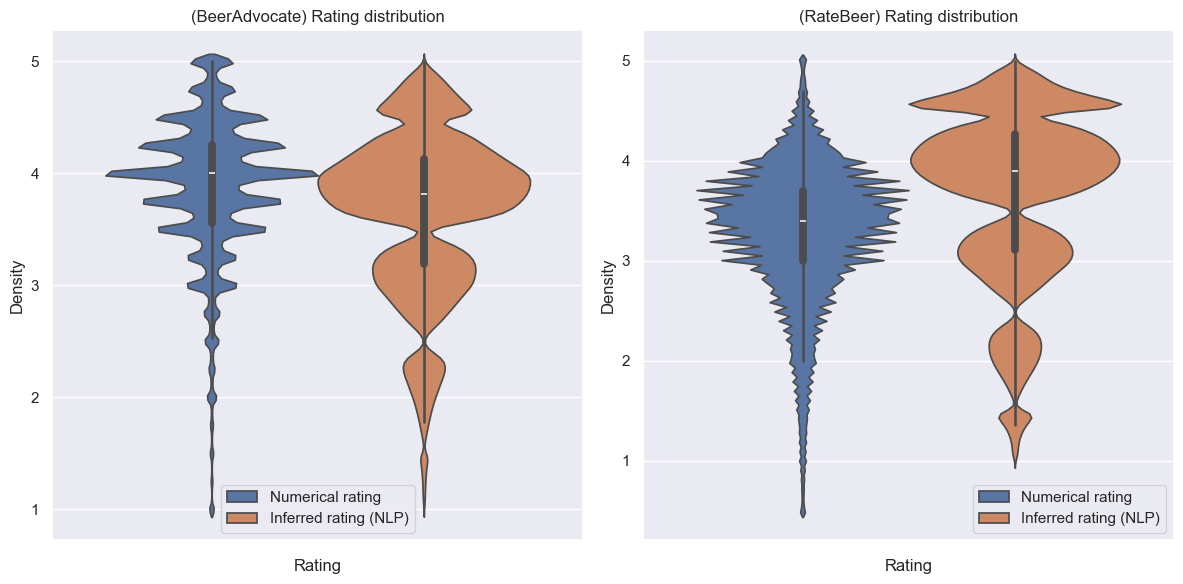

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.ravel()

axs[0].set_title("(BeerAdvocate) Rating distribution")
axs[0].set_xlabel("Rating")
axs[0].set_ylabel("Density")
sns.violinplot(
    df_ba_ratings.rename(
        columns={
            "rating": "Numerical rating",
            "nlp_weighted_rating": "Inferred rating (NLP)",
        }
    ).melt(
        id_vars=["user_id", "beer_id"],
        value_vars=["Numerical rating", "Inferred rating (NLP)"],
    ),
    hue="variable",
    y="value",
    ax=axs[0],
)
axs[0].legend()

axs[1].set_title("(RateBeer) Rating distribution")
axs[1].set_xlabel("Rating")
axs[1].set_ylabel("Density")
sns.violinplot(
    df_rb_ratings.rename(
        columns={
            "rating": "Numerical rating",
            "nlp_weighted_rating": "Inferred rating (NLP)",
        }
    ).melt(
        id_vars=["user_id", "beer_id"],
        value_vars=["Numerical rating", "Inferred rating (NLP)"],
    ),
    hue="variable",
    y="value",
    ax=axs[1],
)
axs[1].legend()

plt.tight_layout()
plt.show()

## User region

In [65]:
NLP_MIN_USERS_PER_REGION = 100

df_ba_nlp_regions = df_ba_ratings.dropna(subset=["user_country_region"])
df_rb_nlp_regions = df_rb_ratings.dropna(subset=["user_country_region"])

ba_users_per_region = df_ba_nlp_regions["user_country_region"].value_counts()
ba_users_per_region = ba_users_per_region[
    ba_users_per_region >= NLP_MIN_USERS_PER_REGION
]
df_ba_nlp_regions = df_ba_nlp_regions[
    df_ba_nlp_regions["user_country_region"].isin(ba_users_per_region.index)
]

rb_users_per_region = df_rb_nlp_regions["user_country_region"].value_counts()
rb_users_per_region = rb_users_per_region[
    rb_users_per_region >= NLP_MIN_USERS_PER_REGION
]
df_rb_nlp_regions = df_rb_nlp_regions[
    df_rb_nlp_regions["user_country_region"].isin(rb_users_per_region.index)
]

In [66]:
NLP_ERROR_COLUMN = "rating_relative_error"
anova_result = f_oneway(
    *[
        group[NLP_ERROR_COLUMN].values
        for _, group in df_ba_nlp_regions.groupby("user_country_region")
    ]
)
print(f"BeerAdvocate ANOVA result: {anova_result}")

anova_result = f_oneway(
    *[
        group[NLP_ERROR_COLUMN].values
        for _, group in df_rb_nlp_regions.groupby("user_country_region")
    ]
)
print(f"RateBeer ANOVA result: {anova_result}")

BeerAdvocate ANOVA result: F_onewayResult(statistic=128.75110717991055, pvalue=0.0)
RateBeer ANOVA result: F_onewayResult(statistic=1459.758514482724, pvalue=0.0)


In [68]:
df_ba_nlp_tuckey = tukey_test(
    df_ba_nlp_regions, "user_country_region", NLP_ERROR_COLUMN
)
df_rb_nlp_tuckey = tukey_test(
    df_ba_nlp_regions, "user_country_region", NLP_ERROR_COLUMN
)

In [70]:
G_ba = create_digraph(df_ba_nlp_tuckey, df_ba_nlp_regions, NLP_ERROR_COLUMN)
G_rb = create_digraph(df_rb_nlp_tuckey, df_rb_nlp_regions, NLP_ERROR_COLUMN)

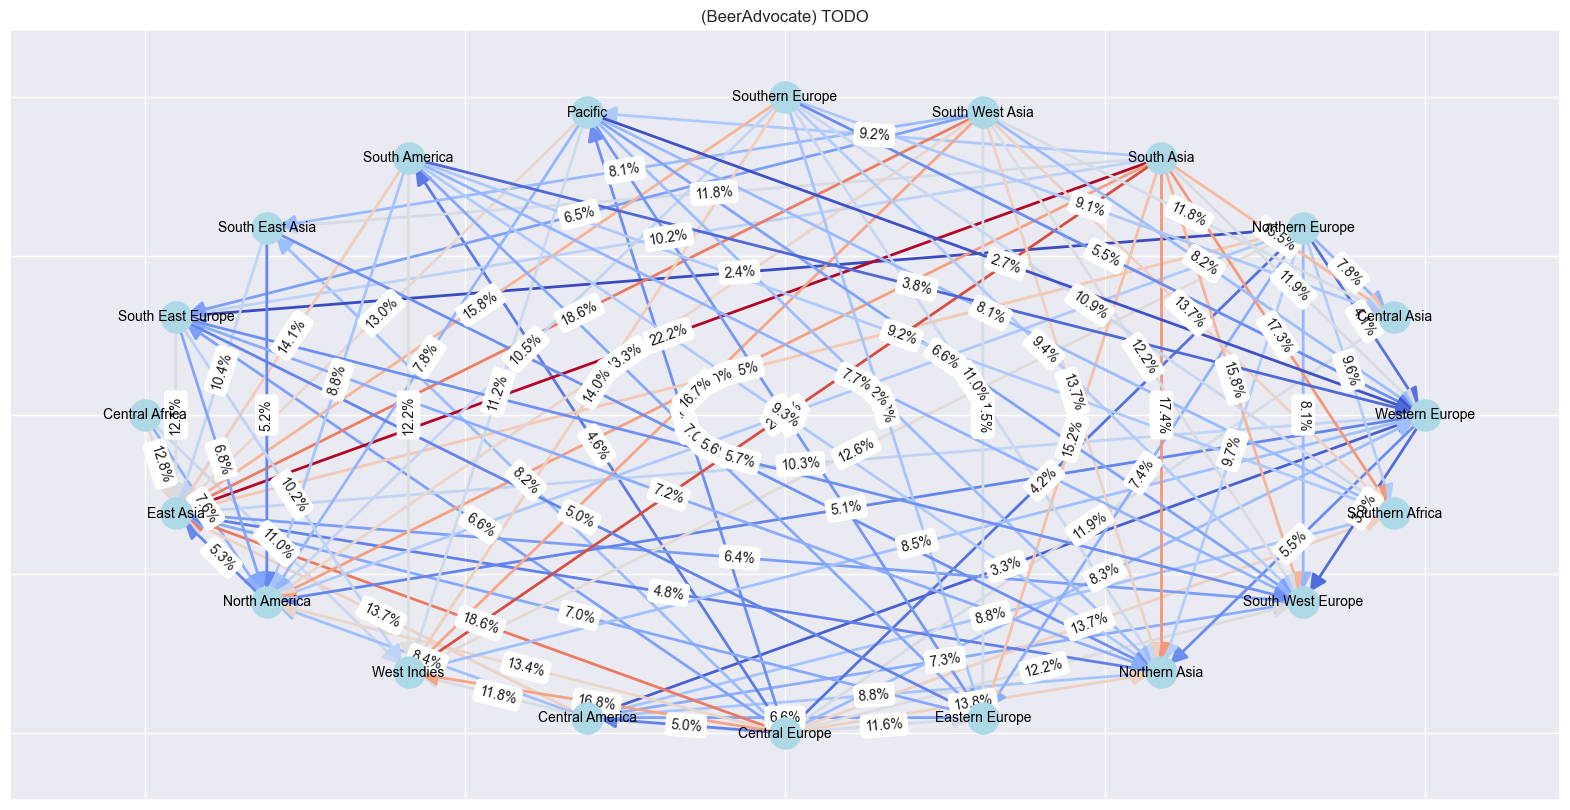

In [71]:
plt.figure(figsize=(20, 10))

plt.title("(BeerAdvocate) TODO")
pos = nx.shell_layout(G_ba)

edges = G_ba.edges(data=True)
edge_colors = [d["difference"] for (_, _, d) in edges]
edge_widths = [2 for (_, _, d) in edges]

nx.draw_networkx_nodes(G_ba, pos, node_size=500, node_color="lightblue")
nx.draw_networkx_edges(
    G_ba,
    pos,
    edge_color=edge_colors,
    width=edge_widths,
    edge_cmap=plt.cm.coolwarm,
    arrowsize=25,
)
nx.draw_networkx_labels(
    G_ba,
    pos,
    font_size=10,
    font_color="black",
)
nx.draw_networkx_edge_labels(
    G_ba,
    pos,
    edge_labels={(u, v): f"{d['difference']*100:.1f}%" for (u, v, d) in edges},
)

plt.show()

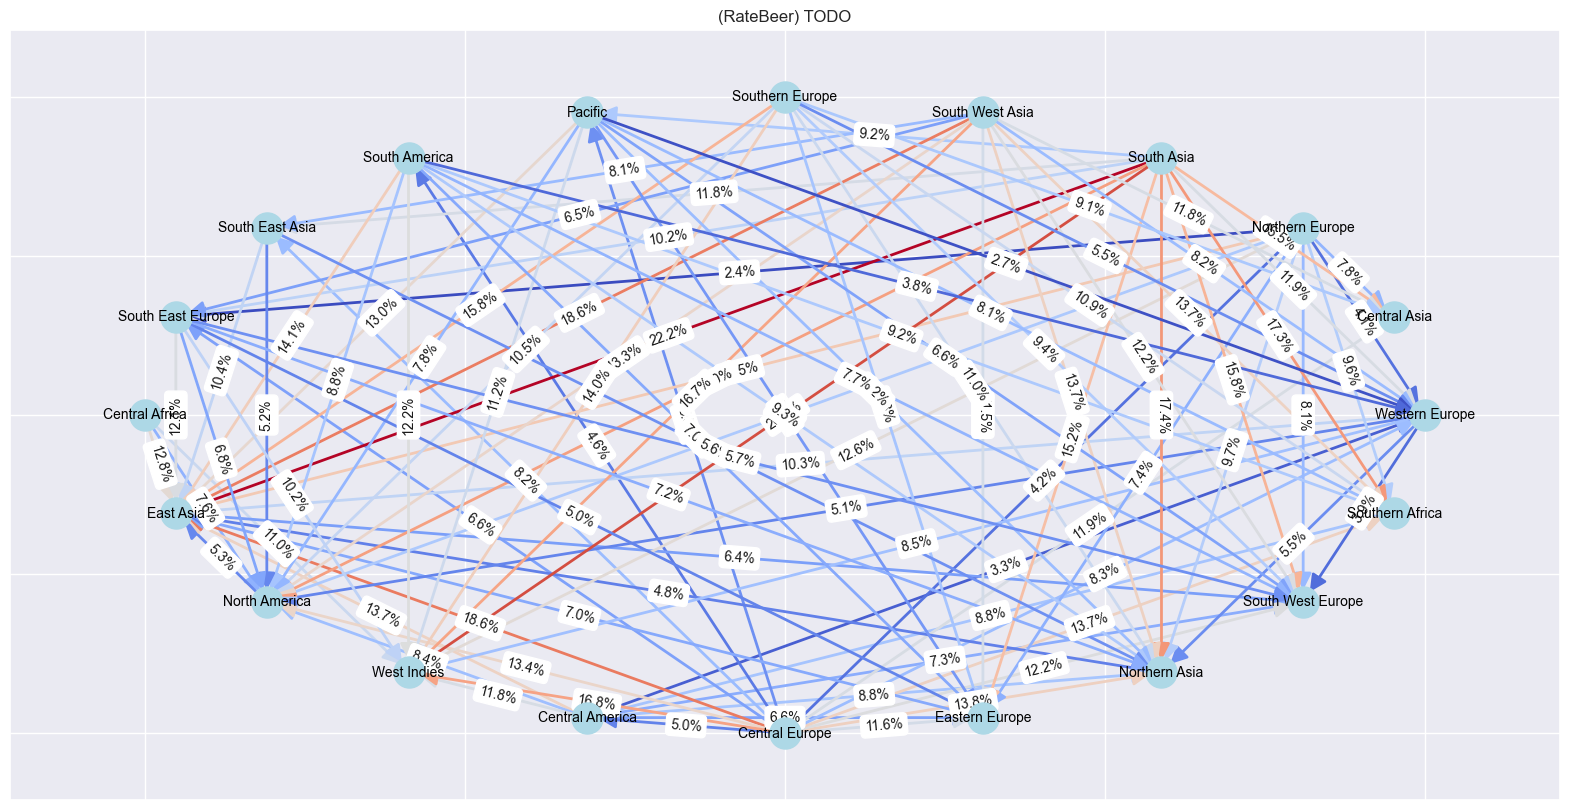

In [72]:
plt.figure(figsize=(20, 10))

plt.title("(RateBeer) TODO")
pos = nx.shell_layout(G_rb)

edges = G_rb.edges(data=True)
edge_colors = [d["difference"] for (_, _, d) in edges]
edge_widths = [2 for (_, _, d) in edges]

nx.draw_networkx_nodes(G_rb, pos, node_size=500, node_color="lightblue")
nx.draw_networkx_edges(
    G_rb,
    pos,
    edge_color=edge_colors,
    width=edge_widths,
    edge_cmap=plt.cm.coolwarm,
    arrowsize=25,
)
nx.draw_networkx_labels(
    G_rb,
    pos,
    font_size=10,
    font_color="black",
)
nx.draw_networkx_edge_labels(
    G_rb,
    pos,
    edge_labels={(u, v): f"{d['difference']*100:.1f}%" for (u, v, d) in edges},
)

plt.show()

In [73]:
print(
    f"BeerAdvocate : nx.is_directed_acyclic_graph(G_ba)={nx.is_directed_acyclic_graph(G_ba)}"
)
print(
    f"RateBeer :  nx.is_directed_acyclic_graph(G_rb)={nx.is_directed_acyclic_graph(G_rb)}"
)

BeerAdvocate : nx.is_directed_acyclic_graph(G_ba)=True
RateBeer :  nx.is_directed_acyclic_graph(G_rb)=True


# 6. Preferences 

In [74]:
df_ba_ratings["dominant_style"] = df_ba_ratings.groupby("user_id")[
    "beer_global_style"
].transform(lambda x: x.mode()[0])
df_rb_ratings["dominant_style"] = df_rb_ratings.groupby("user_id")[
    "beer_global_style"
].transform(lambda x: x.mode()[0])

In [76]:
df_ba_relationships = analyse_relationships(df_ba_ratings)
df_rb_relationships = analyse_relationships(df_rb_ratings)

In [78]:
G_ba_preferences = create_preference_digraph(df_ba_relationships)
G_rb_preferences = create_preference_digraph(df_rb_relationships)

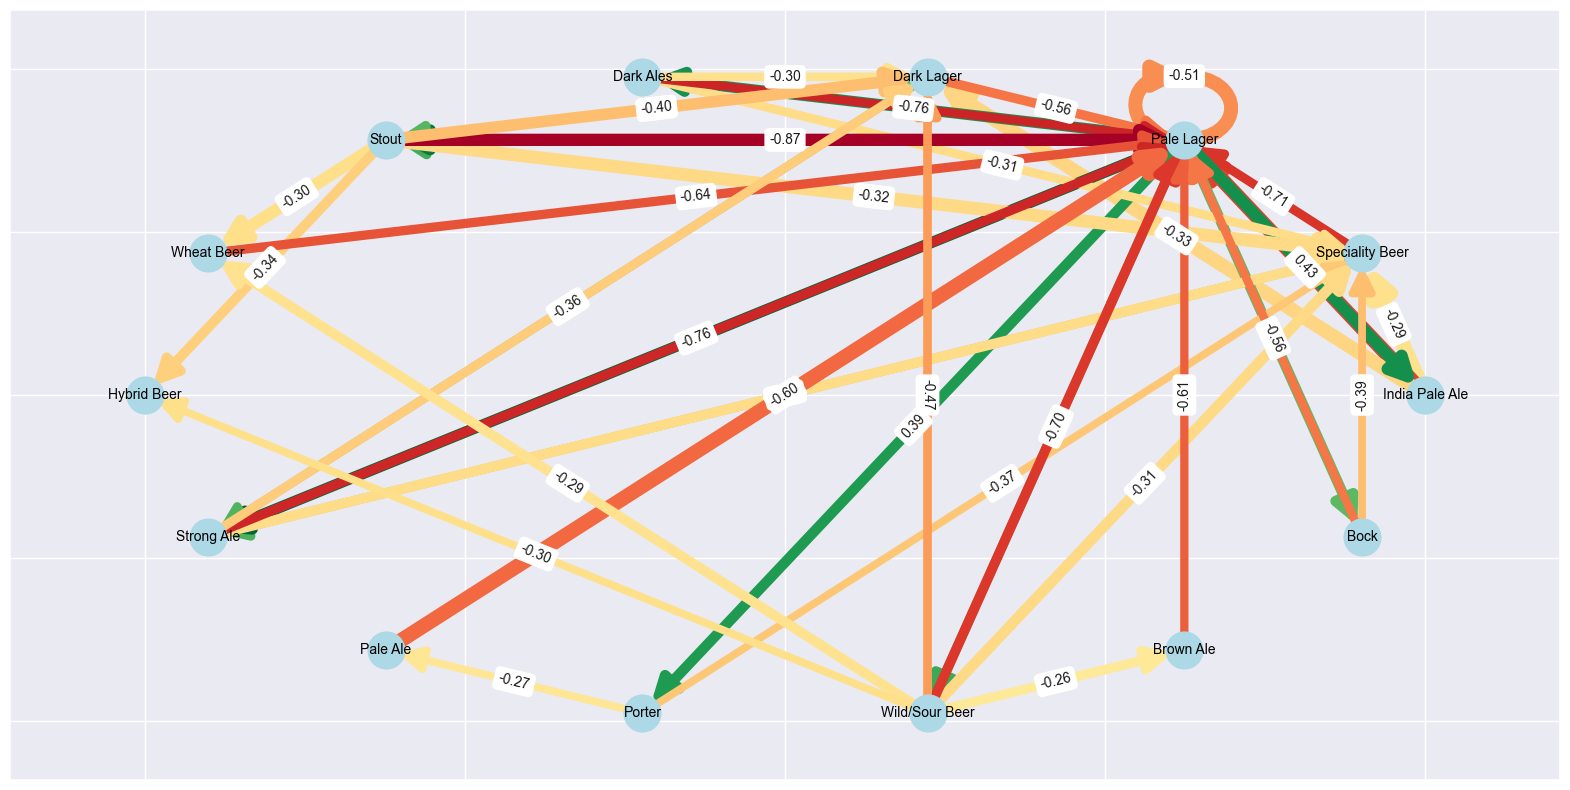

In [79]:
pos = nx.circular_layout(G_ba_preferences)
plt.figure(figsize=(20, 10))

nx.draw_networkx_nodes(G_ba_preferences, pos, node_size=700, node_color="lightblue")

edges = G_ba_preferences.edges(data=True)
edge_colors = [d["rating"] for (_, _, d) in edges]
edge_widths = [np.log(d["weight"]) for (_, _, d) in edges]  # Scale thickness

nx.draw_networkx_edges(
    G_ba_preferences,
    pos,
    edge_color=edge_colors,
    width=edge_widths,
    edge_cmap=plt.cm.RdYlGn,
    arrowsize=35,
)
nx.draw_networkx_labels(G_ba_preferences, pos, font_size=10, font_color="black")
nx.draw_networkx_edge_labels(
    G_ba_preferences,
    pos,
    edge_labels={(u, v): f"{d['rating']:.2f}" for (u, v, d) in edges},
)

plt.show()

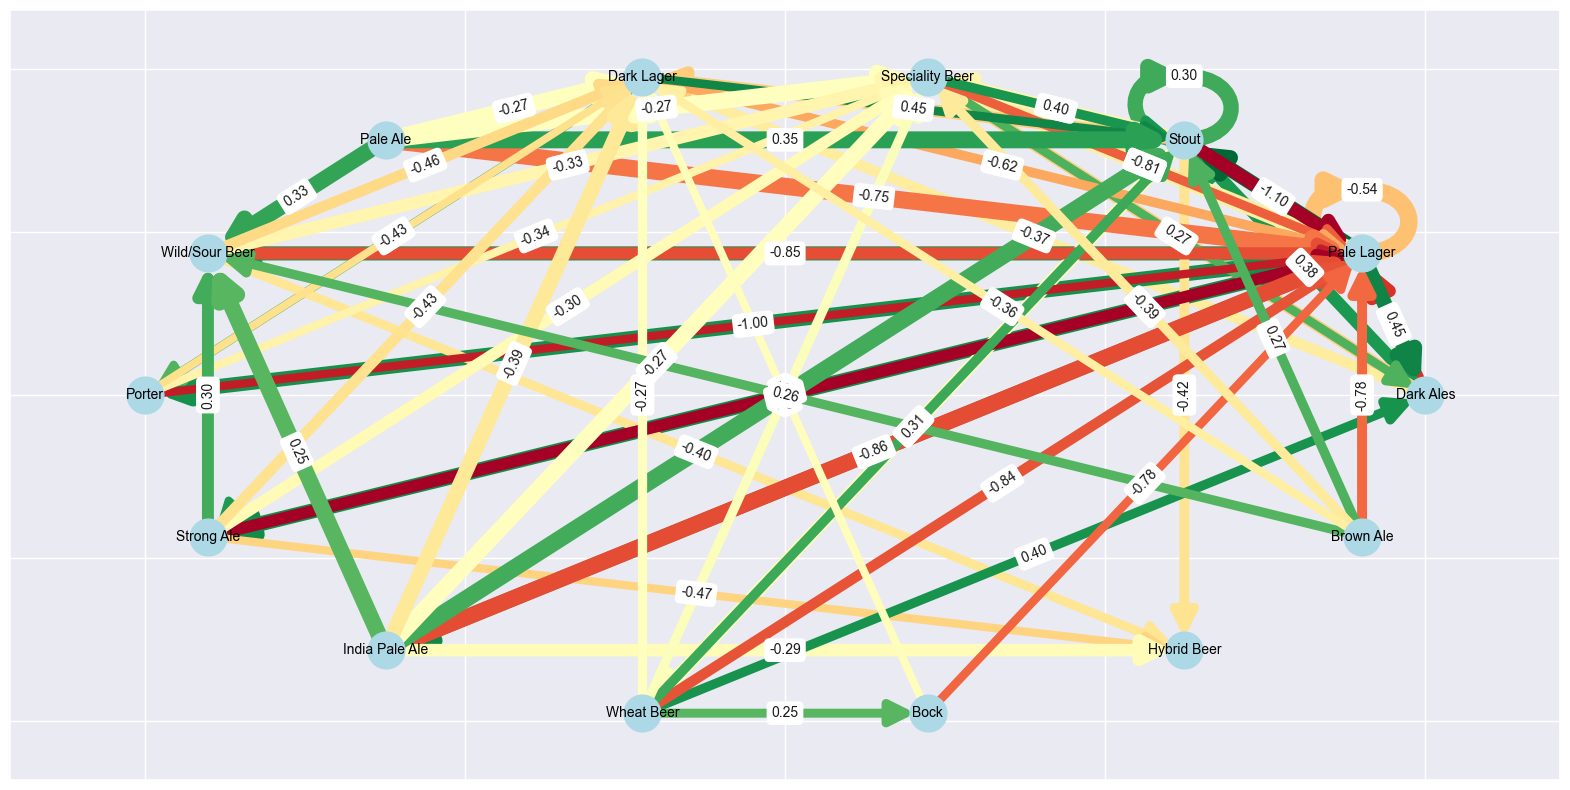

In [80]:
pos = nx.circular_layout(G_rb_preferences)
plt.figure(figsize=(20, 10))

nx.draw_networkx_nodes(G_rb_preferences, pos, node_size=700, node_color="lightblue")

edges = G_rb_preferences.edges(data=True)
edge_colors = [d["rating"] for (_, _, d) in edges]
edge_widths = [np.log(d["weight"]) for (_, _, d) in edges]  # Scale thickness

nx.draw_networkx_edges(
    G_rb_preferences,
    pos,
    edge_color=edge_colors,
    width=edge_widths,
    edge_cmap=plt.cm.RdYlGn,
    arrowsize=35,
)
nx.draw_networkx_labels(G_rb_preferences, pos, font_size=10, font_color="black")
nx.draw_networkx_edge_labels(
    G_rb_preferences,
    pos,
    edge_labels={(u, v): f"{d['rating']:.2f}" for (u, v, d) in edges},
)

plt.show()